In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score

import time
import psutil
import threading
from memory_profiler import memory_usage


In [60]:
def apply_rf(X_train, y_train, best_params=None, random_state=42, n_jobs=-1, cv=5): 
    measurement_rf = {}
        
    # Default to empty dictionary if best_params is not provided
    best_params = best_params or {}

    rf_model = RandomForestClassifier(**best_params, random_state=random_state, n_jobs=n_jobs, verbose=1)
    
    # Function to monitor CPU usage during training
    cpu_usage = []
    stop_flag = threading.Event()

    def monitor_cpu():
        while not stop_flag.is_set():
            cpu_usage.append(psutil.cpu_percent(interval=0.1))

    # Function to train the model
    def train_model():
        rf_model.fit(X_train, y_train)

    try:
        # Start CPU monitoring in a separate thread
        cpu_thread = threading.Thread(target=monitor_cpu)
        cpu_thread.start()

        # Measure memory usage and training time
        start_time = time.time()
        train_memory_rf = max(memory_usage((train_model,)))  # Measure peak memory usage
        training_time = time.time() - start_time

        # Stop CPU monitoring
        stop_flag.set()
        cpu_thread.join()

        # Add measurements
        measurement_rf['Memory Usage (MB)'] = train_memory_rf
        measurement_rf['Training Time (s)'] = training_time
        measurement_rf['Peak CPU Usage (%)'] = max(cpu_usage)
        measurement_rf['Average CPU Usage (%)'] = sum(cpu_usage) / len(cpu_usage) if cpu_usage else 0

        # Perform cross-validation
        cv_scores_rf = cross_val_score(rf_model, X_train, y_train, cv=cv, n_jobs=n_jobs)

        return cv_scores_rf, measurement_rf, rf_model

    except Exception as e:
        import traceback
        print("⛔ Full error traceback:")
        traceback.print_exc()  # Print detailed error traceback
        print(f"Error during Random Forest training: {e}")
        return None, None, None

In [61]:
def eval_dataset_w_RF(df, target_column="Label"):
    X = df.drop(target_column, axis=1)
    y = df[target_column]


    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
    params_rf = {'n_estimators': 150, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 10}

    # Fitting the model
    cv_scores_rf, measurement_rf, rf_model = apply_rf(X_train, y_train, best_params=params_rf)

    # Making predictions
    y_pred_rf = rf_model.predict(X_test)
    
    # Evaluating the model performance on the cross validation set vs accuracy on the test set
    cv_scores_mean_rf = np.mean(cv_scores_rf)
    print(f'Cross validation average score: {cv_scores_mean_rf:.4f} +/- standard deviation: {np.std(cv_scores_rf):.4f}')

    accuracy_rf = accuracy_score(y_test, y_pred_rf)
    print(f'Accuracy on the test set: {accuracy_rf:.4f}')
    
    # Checking computational cost
    print("Resource measurements:", measurement_rf)
    print(classification_report(y_test, y_pred_rf))

In [5]:
def get_feature_types(df, target_col='Label'):
    numeric_features = df.select_dtypes(include=[np.number]).columns.tolist()
    categorical_features = df.select_dtypes(include=['object']).columns.tolist()

    # Remove target column if present
    if target_col in numeric_features:
        numeric_features.remove(target_col)
    if target_col in categorical_features:
        categorical_features.remove(target_col)

    return numeric_features, categorical_features

In [63]:
df = pd.read_csv('cicids2017_COMBINED.csv', engine='python',)

In [64]:
df.head()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,54865,3,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,55054,109,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,55055,52,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,46236,34,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,54863,3,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


In [65]:
df.columns = df.columns.str.rstrip()
df.columns = df.columns.str.strip()

In [66]:
df.columns

Index(['Destination Port', 'Flow Duration', 'Total Fwd Packets',
       'Total Backward Packets', 'Total Length of Fwd Packets',
       'Total Length of Bwd Packets', 'Fwd Packet Length Max',
       'Fwd Packet Length Min', 'Fwd Packet Length Mean',
       'Fwd Packet Length Std', 'Bwd Packet Length Max',
       'Bwd Packet Length Min', 'Bwd Packet Length Mean',
       'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s',
       'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min',
       'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max',
       'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std',
       'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags',
       'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length',
       'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s',
       'Min Packet Length', 'Max Packet Length', 'Packet Length Mean',
       'Packet Length Std', 'Packet Length Variance', 'FIN Flag Count',
       'SYN Flag Co

In [67]:
df.shape

(2830743, 79)

In [68]:
df["Label"].unique()[1:]

array(['DDoS', 'PortScan', 'Bot', 'Infiltration',
       'Web Attack � Brute Force', 'Web Attack � XSS',
       'Web Attack � Sql Injection', 'FTP-Patator', 'SSH-Patator',
       'DoS slowloris', 'DoS Slowhttptest', 'DoS Hulk', 'DoS GoldenEye',
       'Heartbleed'], dtype=object)

# Data Cleaning

In [ ]:
# Before we start we can't have any nans and infs so we'll quickly remove them
df_noInfs = df.replace([np.inf, -np.inf], np.nan)
df_noNaNs = df_noInfs.dropna()
del df_noInfs

In [69]:
# Result of RF before any datacleaning
eval_dataset_w_RF(df_noNaNs)
del df_noNaNs

NameError: name 'df_noNaNs' is not defined

In [72]:
df.columns = df.columns.str.strip()
df = df.drop(columns=['Fwd Header Length.1'])
df.shape

(2830743, 78)

In [73]:
df['Label'].unique()

array(['BENIGN', 'DDoS', 'PortScan', 'Bot', 'Infiltration',
       'Web Attack � Brute Force', 'Web Attack � XSS',
       'Web Attack � Sql Injection', 'FTP-Patator', 'SSH-Patator',
       'DoS slowloris', 'DoS Slowhttptest', 'DoS Hulk', 'DoS GoldenEye',
       'Heartbleed'], dtype=object)

Features with at least one NaN or Infinity value:
Flow Bytes/s      2867
Flow Packets/s    2867
dtype: int64


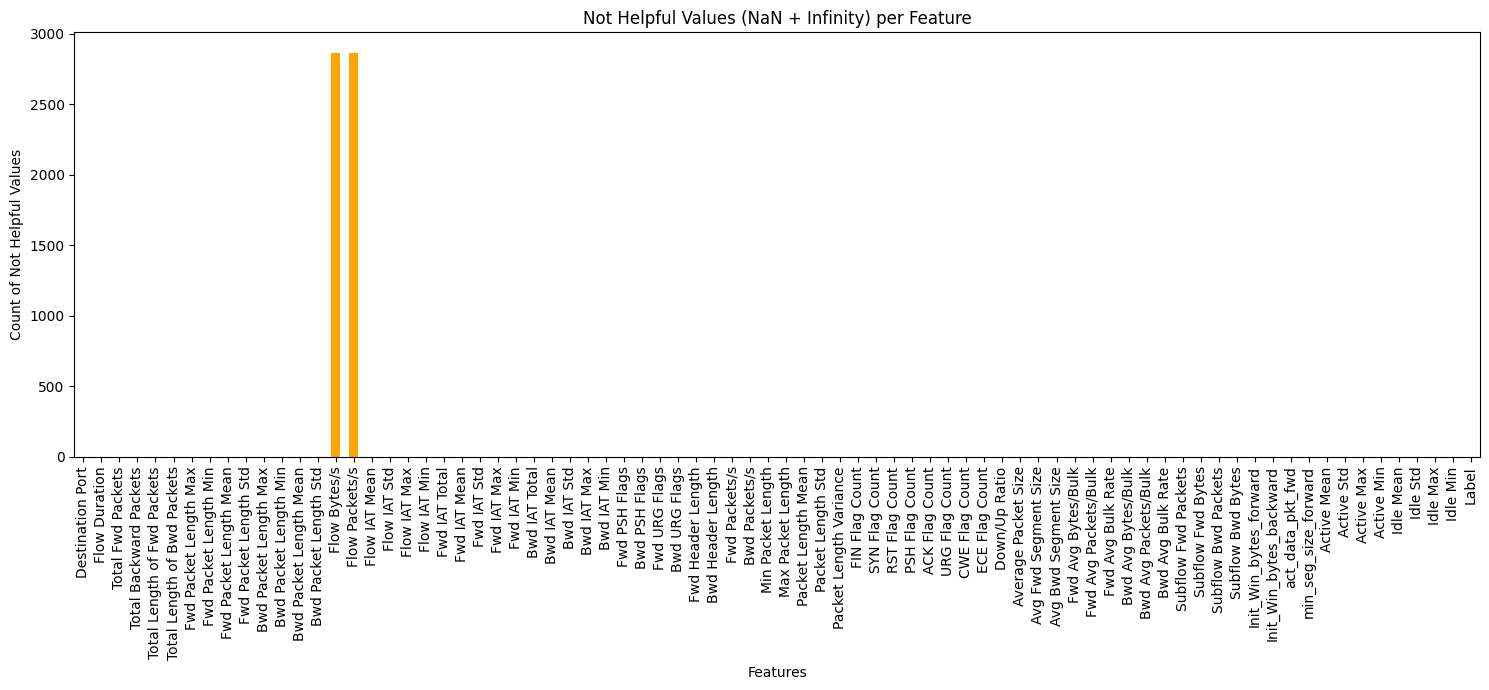

In [74]:
nan_counts = df.isna().sum()
def count_infs(col):
    if pd.api.types.is_numeric_dtype(col):
        return np.isinf(col).sum()
    else:
        return 0
inf_counts = df.apply(count_infs)
not_helpful_counts = nan_counts + inf_counts
features_with_issue = not_helpful_counts[not_helpful_counts > 0]
print("Features with at least one NaN or Infinity value:")
print(features_with_issue)
plt.figure(figsize=(15, 7))
not_helpful_counts.plot(kind='bar', color='orange')
plt.title("Not Helpful Values (NaN + Infinity) per Feature")
plt.xlabel("Features")
plt.ylabel("Count of Not Helpful Values")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [75]:
# Checking for infinite values
num_columns = df.select_dtypes(include = np.number).columns
has_infinite = np.isinf(df[num_columns]).sum()
print(has_infinite[has_infinite > 0])

Flow Bytes/s      1509
Flow Packets/s    2867
dtype: int64


In [76]:
# Treating infinite values
df.replace([np.inf, -np.inf], np.nan, inplace=True)

In [77]:
# Attack counts
attack_counts = df['Label'].value_counts().reset_index()
attack_counts.columns = ['Attack Type', 'Number of Occurrences']

# Duplicating the df and dropping rows with missing values
data_no_na = df.dropna()

# Counting the total number of occurrences of each attack after dropping
occurrences_nonull = data_no_na['Label'].value_counts().reset_index()
occurrences_nonull.columns = ['Attack Type', 'Occurrences w/o Null Rows']

# Merging the DataFrames
attack_counts = attack_counts.merge(occurrences_nonull, on='Attack Type', how='left')

# Calculating the difference
attack_counts['Abs Difference'] = attack_counts['Number of Occurrences'] - attack_counts['Occurrences w/o Null Rows']
attack_counts['Difference %'] = ((attack_counts['Abs Difference'] * 100) / attack_counts['Number of Occurrences']).round(2)

# Visualization
attack_counts

,Attack Type,Number of Occurrences,Occurrences w/o Null Rows,Abs Difference,Difference %
0,BENIGN,2273097,2271320,1777,0.08
1,DoS Hulk,231073,230124,949,0.41
2,PortScan,158930,158804,126,0.08
3,DDoS,128027,128025,2,0.00
4,DoS GoldenEye,10293,10293,0,0.00
5,FTP-Patator,7938,7935,3,0.04
6,SSH-Patator,5897,5897,0,0.00
7,DoS slowloris,5796,5796,0,0.00
8,DoS Slowhttptest,5499,5499,0,0.00
9,Bot,1966,1956,10,0.51


In [78]:
# Cleaning up
del data_no_na

# Evaluating percentage of missing values per column
threshold = 10
missing_percentage = (df.isnull().sum() / len(df)) * 100

# Filter columns with missing values over the threshold
high_missing_cols = missing_percentage[missing_percentage > threshold]

# Print columns with high missing percentages
if len(high_missing_cols) > 0:
    print(f'The following columns have over {threshold}% of missing values:')
    print(high_missing_cols)
else:
    print('There are no columns with missing values greater than the threshold')

There are no columns with missing values greater than the threshold


In [79]:
row_missing_percentage = (df.isna().sum(axis=1) / df.shape[1]) * 100
print(row_missing_percentage.describe())

missing_rows = df.isna().any(axis=1).sum()
print(f'\nTotal rows with missing values: {missing_rows}')

count    2.830743e+06
mean     2.596944e-03
std      8.156035e-02
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      2.564103e+00
dtype: float64

Total rows with missing values: 2867


In [80]:
# Dropping missing values
df = df.dropna()
print(f'Dataset shape after row-wise removal: {df.shape}')

Dataset shape after row-wise removal: (2827876, 78)


In [81]:
nan_counts = df.isna().sum()
inf_counts = df.apply(count_infs)
print("Features with NaNs")
print(nan_counts[nan_counts>0])
print("Features with Infs")
print(inf_counts[inf_counts>0])

Features with NaNs
Series([], dtype: int64)
Features with Infs
Series([], dtype: int64)


In [82]:
string_features = list(df.select_dtypes(include=['object']).columns)
string_features.remove('Label')
string_features

[]

In [83]:
le = preprocessing.LabelEncoder()
df[string_features] = df[string_features].apply(lambda col: le.fit_transform(col))
df['Label'].value_counts()

Label
BENIGN                        2271320
DoS Hulk                       230124
PortScan                       158804
DDoS                           128025
DoS GoldenEye                   10293
FTP-Patator                      7935
SSH-Patator                      5897
DoS slowloris                    5796
DoS Slowhttptest                 5499
Bot                              1956
Web Attack � Brute Force         1507
Web Attack � XSS                  652
Infiltration                       36
Web Attack � Sql Injection         21
Heartbleed                         11
Name: count, dtype: int64

In [84]:
col_names = {col: col.strip() for col in df.columns}
df.rename(columns = col_names, inplace = True)

In [85]:
print(f"Original shape: {df.shape}")
df = df.drop_duplicates(keep='first')
print(f"Without duplicate rows shape: {df.shape}")

Original shape: (2827876, 78)
Without duplicate rows shape: (2520798, 78)


In [86]:
identical_columns = {}
columns = df.columns
list_control = columns.copy().tolist()

for col1 in columns:
    for col2 in columns:
        if col1 != col2:
            if df[col1].equals(df[col2]):
                if (col1 not in identical_columns) and (col1 in list_control):
                    identical_columns[col1] = [col2]
                    list_control.remove(col2)
                elif (col1 in identical_columns) and (col1 in list_control):
                    identical_columns[col1].append(col2)
                    list_control.remove(col2)

if identical_columns:
    print("Identical columns found:")
    for key, value in identical_columns.items():
        print(f"'{key}' is identical to {value}")
else: print("No identical columns found.")

Identical columns found:
'Total Fwd Packets' is identical to ['Subflow Fwd Packets']
'Total Backward Packets' is identical to ['Subflow Bwd Packets']
'Fwd PSH Flags' is identical to ['SYN Flag Count']
'Bwd PSH Flags' is identical to ['Bwd URG Flags', 'Fwd Avg Bytes/Bulk', 'Fwd Avg Packets/Bulk', 'Fwd Avg Bulk Rate', 'Bwd Avg Bytes/Bulk', 'Bwd Avg Packets/Bulk', 'Bwd Avg Bulk Rate']
'Fwd URG Flags' is identical to ['CWE Flag Count']


In [87]:
for key, value in identical_columns.items():
    df.drop(columns=value, inplace=True)

In [88]:
df.columns

Index(['Destination Port', 'Flow Duration', 'Total Fwd Packets',
       'Total Backward Packets', 'Total Length of Fwd Packets',
       'Total Length of Bwd Packets', 'Fwd Packet Length Max',
       'Fwd Packet Length Min', 'Fwd Packet Length Mean',
       'Fwd Packet Length Std', 'Bwd Packet Length Max',
       'Bwd Packet Length Min', 'Bwd Packet Length Mean',
       'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s',
       'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min',
       'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max',
       'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std',
       'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags',
       'Fwd URG Flags', 'Fwd Header Length', 'Bwd Header Length',
       'Fwd Packets/s', 'Bwd Packets/s', 'Min Packet Length',
       'Max Packet Length', 'Packet Length Mean', 'Packet Length Std',
       'Packet Length Variance', 'FIN Flag Count', 'RST Flag Count',
       'PSH Flag C

In [89]:
df.shape

(2520798, 67)

In [90]:
# Check for numeric columns that contain only a single unique value, indicating no diversity in values.
# Such columns contribute no useful information to the analysis and may be candidates for removal.
only_unique_cols = []
for col in df.columns:
    if len(df[col].unique()) == 1:
        only_unique_cols.append(col)
        print(col)

print(f'\nThe number of columns with only one unique values is: {len(only_unique_cols)}')


Bwd PSH Flags

The number of columns with only one unique values is: 1


In [91]:
# Dropping the columns with only one unique value
df.drop(only_unique_cols, axis=1, inplace=True)
del only_unique_cols

In [92]:
df.shape


(2520798, 66)

In [ ]:
# Result of RF before any datacleaning
eval_dataset_w_RF(df)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   27.4s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  2.3min finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done 150 out of 150 | elapsed:    3.6s finished


Cross validation average score: 0.9958 +/- standard deviation: 0.0001
Accuracy on the test set: 0.9957
Resource measurements: {'Memory Usage (MB)': 7496.5, 'Training Time (s)': 143.31213760375977, 'Peak CPU Usage (%)': 100.0, 'Average CPU Usage (%)': 94.43615384615384}


c:\Users\Pavel\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Pavel\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

                    BENIGN       1.00      1.00      1.00    628518
                       Bot       1.00      0.02      0.04       584
                      DDoS       1.00      1.00      1.00     38404
             DoS GoldenEye       1.00      0.89      0.94      3086
                  DoS Hulk       1.00      0.98      0.99     51854
          DoS Slowhttptest       0.94      0.94      0.94      1568
             DoS slowloris       1.00      0.93      0.96      1616
               FTP-Patator       1.00      1.00      1.00      1779
                Heartbleed       1.00      0.67      0.80         3
              Infiltration       0.00      0.00      0.00        11
                  PortScan       0.99      1.00      0.99     27208
               SSH-Patator       1.00      0.89      0.94       966
  Web Attack � Brute Force       0.00      0.00      0.00       441
Web Attack � Sql Injection       0.00      0.00

c:\Users\Pavel\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [93]:
# Mapping the attacks to the new group
group_mapping = {
    'BENIGN': 'Normal Traffic',
    'DoS Hulk': 'DoS',
    'DDoS': 'DDoS',
    'PortScan': 'Port Scanning',
    'DoS GoldenEye': 'DoS',
    'FTP-Patator': 'Brute Force',
    'DoS slowloris': 'DoS',
    'DoS Slowhttptest': 'DoS',
    'SSH-Patator': 'Brute Force',
    'Bot': 'Bots',
    'Web Attack � Brute Force': 'Web Attacks',
    'Web Attack � XSS': 'Web Attacks',
    'Infiltration': 'Infiltration',
    'Web Attack � Sql Injection': 'Web Attacks',
    'Heartbleed': 'Miscellaneous'
}

# Map to new group column
df['Attack Type'] = df['Label'].map(group_mapping)

In [94]:
print(df['Attack Type'].value_counts())
df.drop(columns='Label', inplace=True)

Attack Type
Normal Traffic    2095057
DoS                193745
DDoS               128014
Port Scanning       90694
Brute Force          9150
Web Attacks          2143
Bots                 1948
Infiltration           36
Miscellaneous          11
Name: count, dtype: int64


In [ ]:
df.head()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Attack Type
0,54865,3,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,Normal Traffic
1,55054,109,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,Normal Traffic
2,55055,52,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,Normal Traffic
3,46236,34,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,Normal Traffic
4,54863,3,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,Normal Traffic


In [95]:
# Removing rows with statistically irrelevant attack types
df.drop(df[(df['Attack Type'] == 'Infiltration') | (df['Attack Type'] == 'Miscellaneous')].index, inplace=True)

In [96]:
# Data shape and attack counts after removal
print(df.shape)
df['Attack Type'].value_counts()

(2520751, 66)


Attack Type
Normal Traffic    2095057
DoS                193745
DDoS               128014
Port Scanning       90694
Brute Force          9150
Web Attacks          2143
Bots                 1948
Name: count, dtype: int64

In [57]:
# Result of RF before any datacleaning
eval_dataset_w_RF(df, target_column='Attack Type')

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   26.5s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  2.2min finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 150 out of 150 | elapsed:    2.0s finished


Cross validation average score: 0.9959 +/- standard deviation: 0.0001
Accuracy on the test set: 0.9959
Resource measurements: {'Memory Usage (MB)': 7617.9453125, 'Training Time (s)': 136.38939380645752, 'Peak CPU Usage (%)': 100.0, 'Average CPU Usage (%)': 94.98244680851064}


c:\Users\Pavel\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Pavel\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                precision    recall  f1-score   support

          Bots       1.00      0.01      0.03       584
   Brute Force       1.00      0.97      0.98      2745
          DDoS       1.00      1.00      1.00     38404
           DoS       1.00      0.98      0.99     58124
Normal Traffic       1.00      1.00      1.00    628518
 Port Scanning       0.99      1.00      0.99     27208
   Web Attacks       0.00      0.00      0.00       643

      accuracy                           1.00    756226
     macro avg       0.85      0.71      0.71    756226
  weighted avg       1.00      1.00      1.00    756226



c:\Users\Pavel\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Correlation Analysis

In [20]:
import seaborn as sns

In [24]:
def correlation_analysis(df, numeric_features, threshold=0.85):
    # Calculate correlation matrix
    corr_matrix = df[numeric_features].corr()

    # Plot correlation heatmap
    plt.figure(figsize=(20, 20))
    sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0, linewidth = 0.5)
    plt.title('Feature Correlation Heatmap')
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.show()

    # Identify highly correlated features
    threshold = threshold
    high_corr = np.where(np.abs(corr_matrix) > threshold)
    high_corr = [(corr_matrix.index[x], corr_matrix.columns[y], corr_matrix.iloc[x, y])
                 for x, y in zip(*high_corr) if x != y and x < y]

    return high_corr

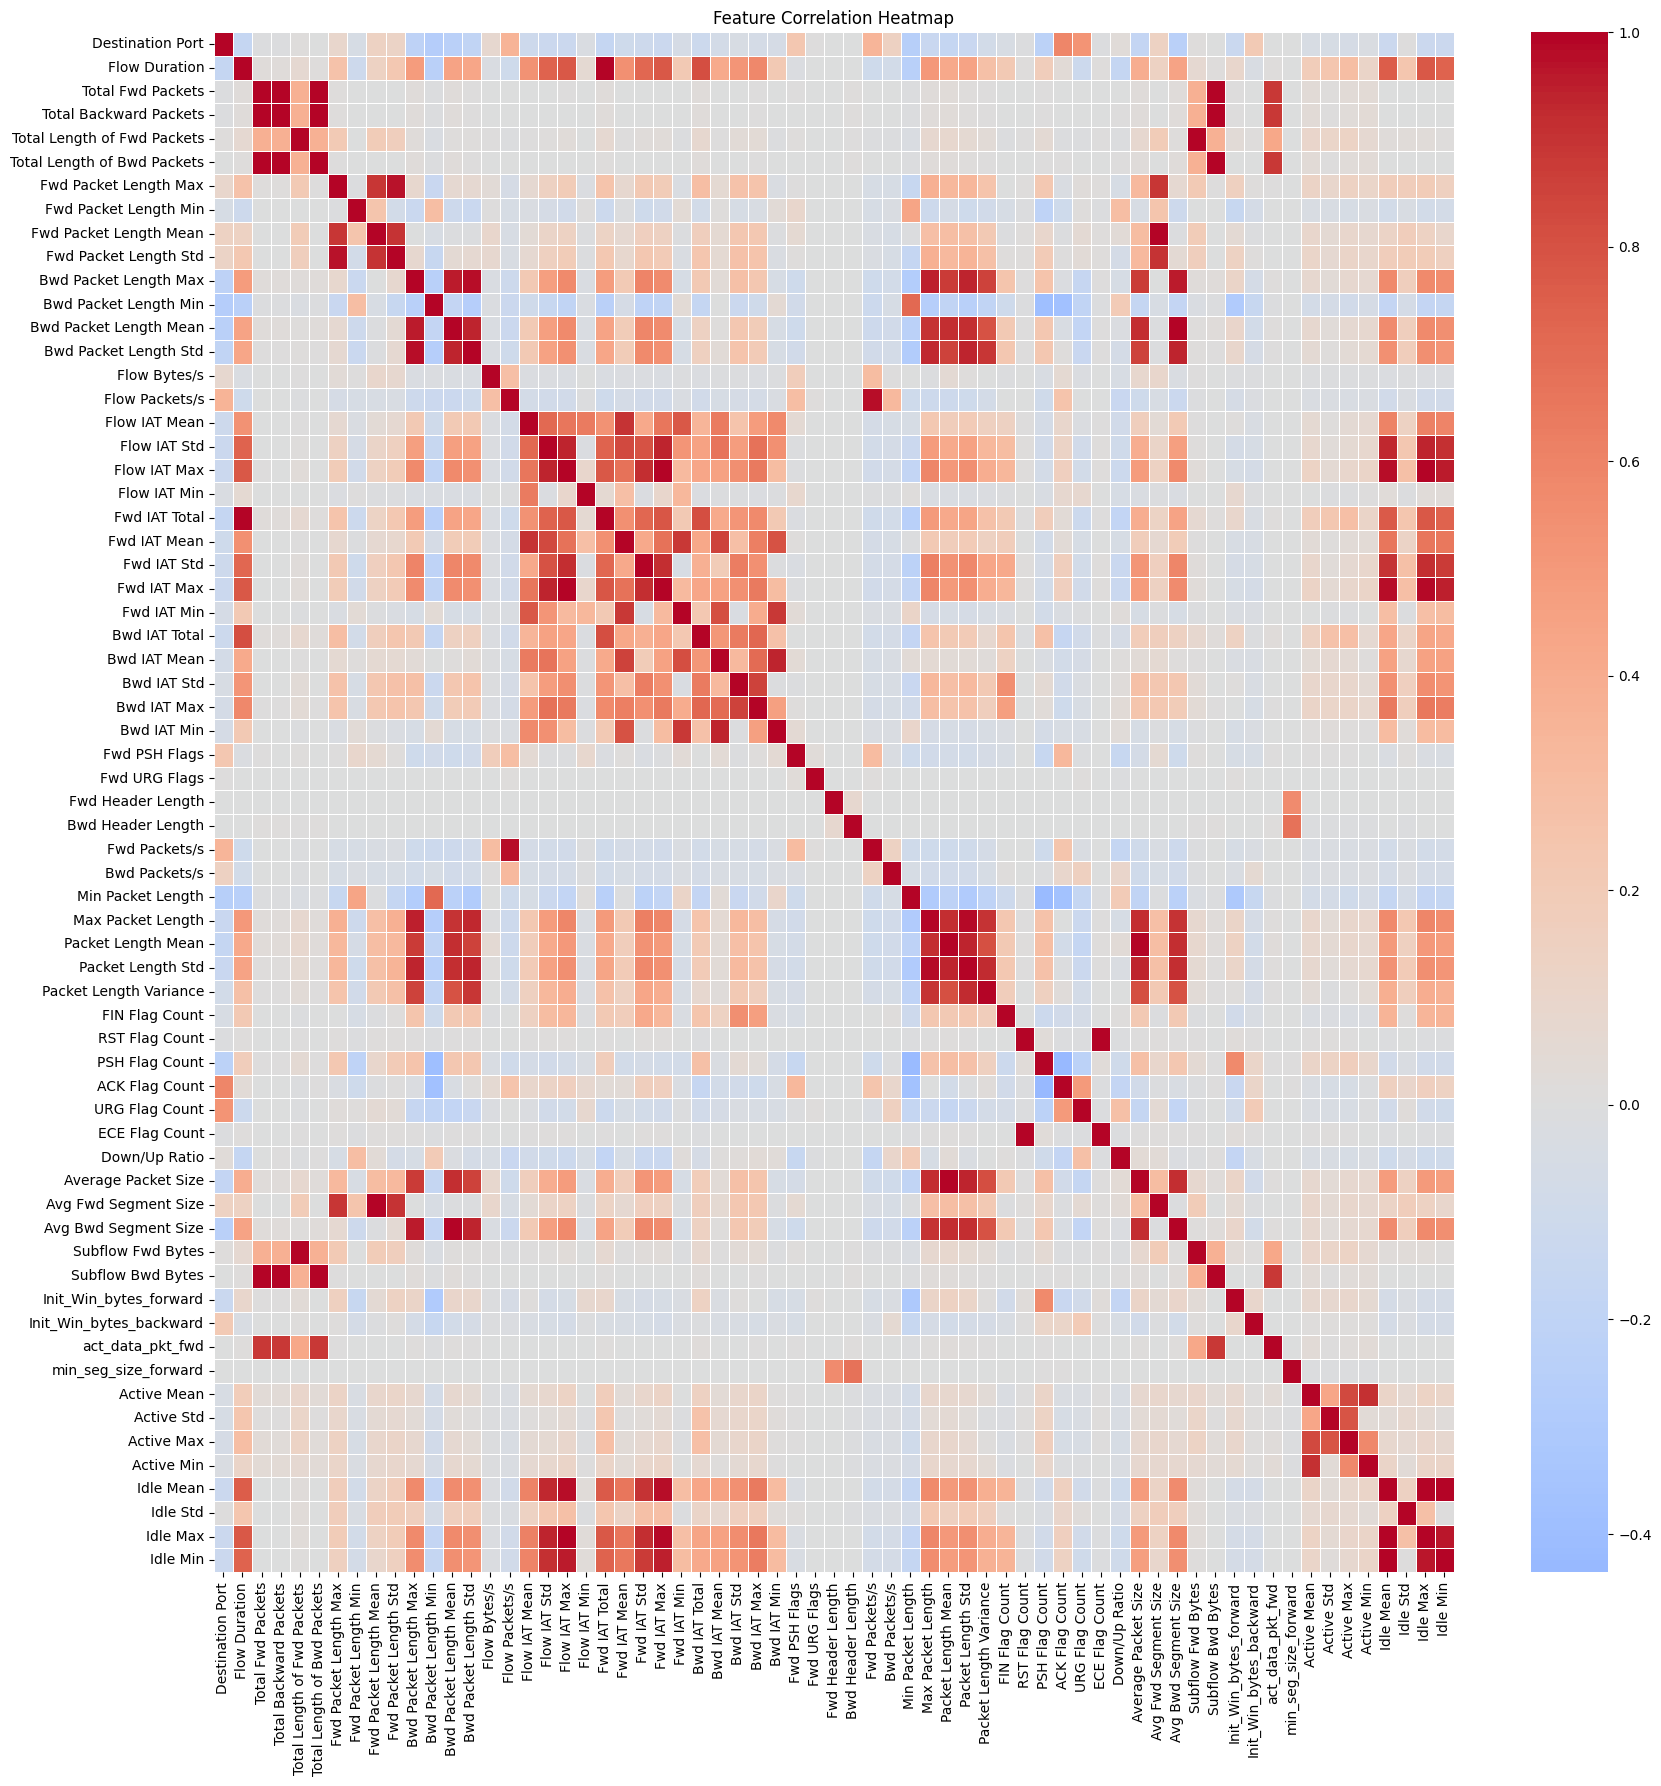

In [99]:
# Correlation Analysis:
numeric_features, categorical_features = get_feature_types(df)
high_corr = correlation_analysis(df, numeric_features)

In [100]:
# Printing the pairs with high correlation and isolating the near/perfect multicollinearity
high_multicollinearity = []
for item in high_corr:
    print(f'{item[0]} has a high correlation with {item[1]}: {item[2].round(4)}')
    if item[2] >= 0.95:
        high_multicollinearity.append(item)

Flow Duration has a high correlation with Fwd IAT Total: 0.9985
Total Fwd Packets has a high correlation with Total Backward Packets: 0.9991
Total Fwd Packets has a high correlation with Total Length of Bwd Packets: 0.997
Total Fwd Packets has a high correlation with Subflow Bwd Bytes: 0.997
Total Fwd Packets has a high correlation with act_data_pkt_fwd: 0.8874
Total Backward Packets has a high correlation with Total Length of Bwd Packets: 0.9945
Total Backward Packets has a high correlation with Subflow Bwd Bytes: 0.9944
Total Backward Packets has a high correlation with act_data_pkt_fwd: 0.8826
Total Length of Fwd Packets has a high correlation with Subflow Fwd Bytes: 1.0
Total Length of Bwd Packets has a high correlation with Subflow Bwd Bytes: 1.0
Total Length of Bwd Packets has a high correlation with act_data_pkt_fwd: 0.884
Fwd Packet Length Max has a high correlation with Fwd Packet Length Mean: 0.889
Fwd Packet Length Max has a high correlation with Fwd Packet Length Std: 0.968

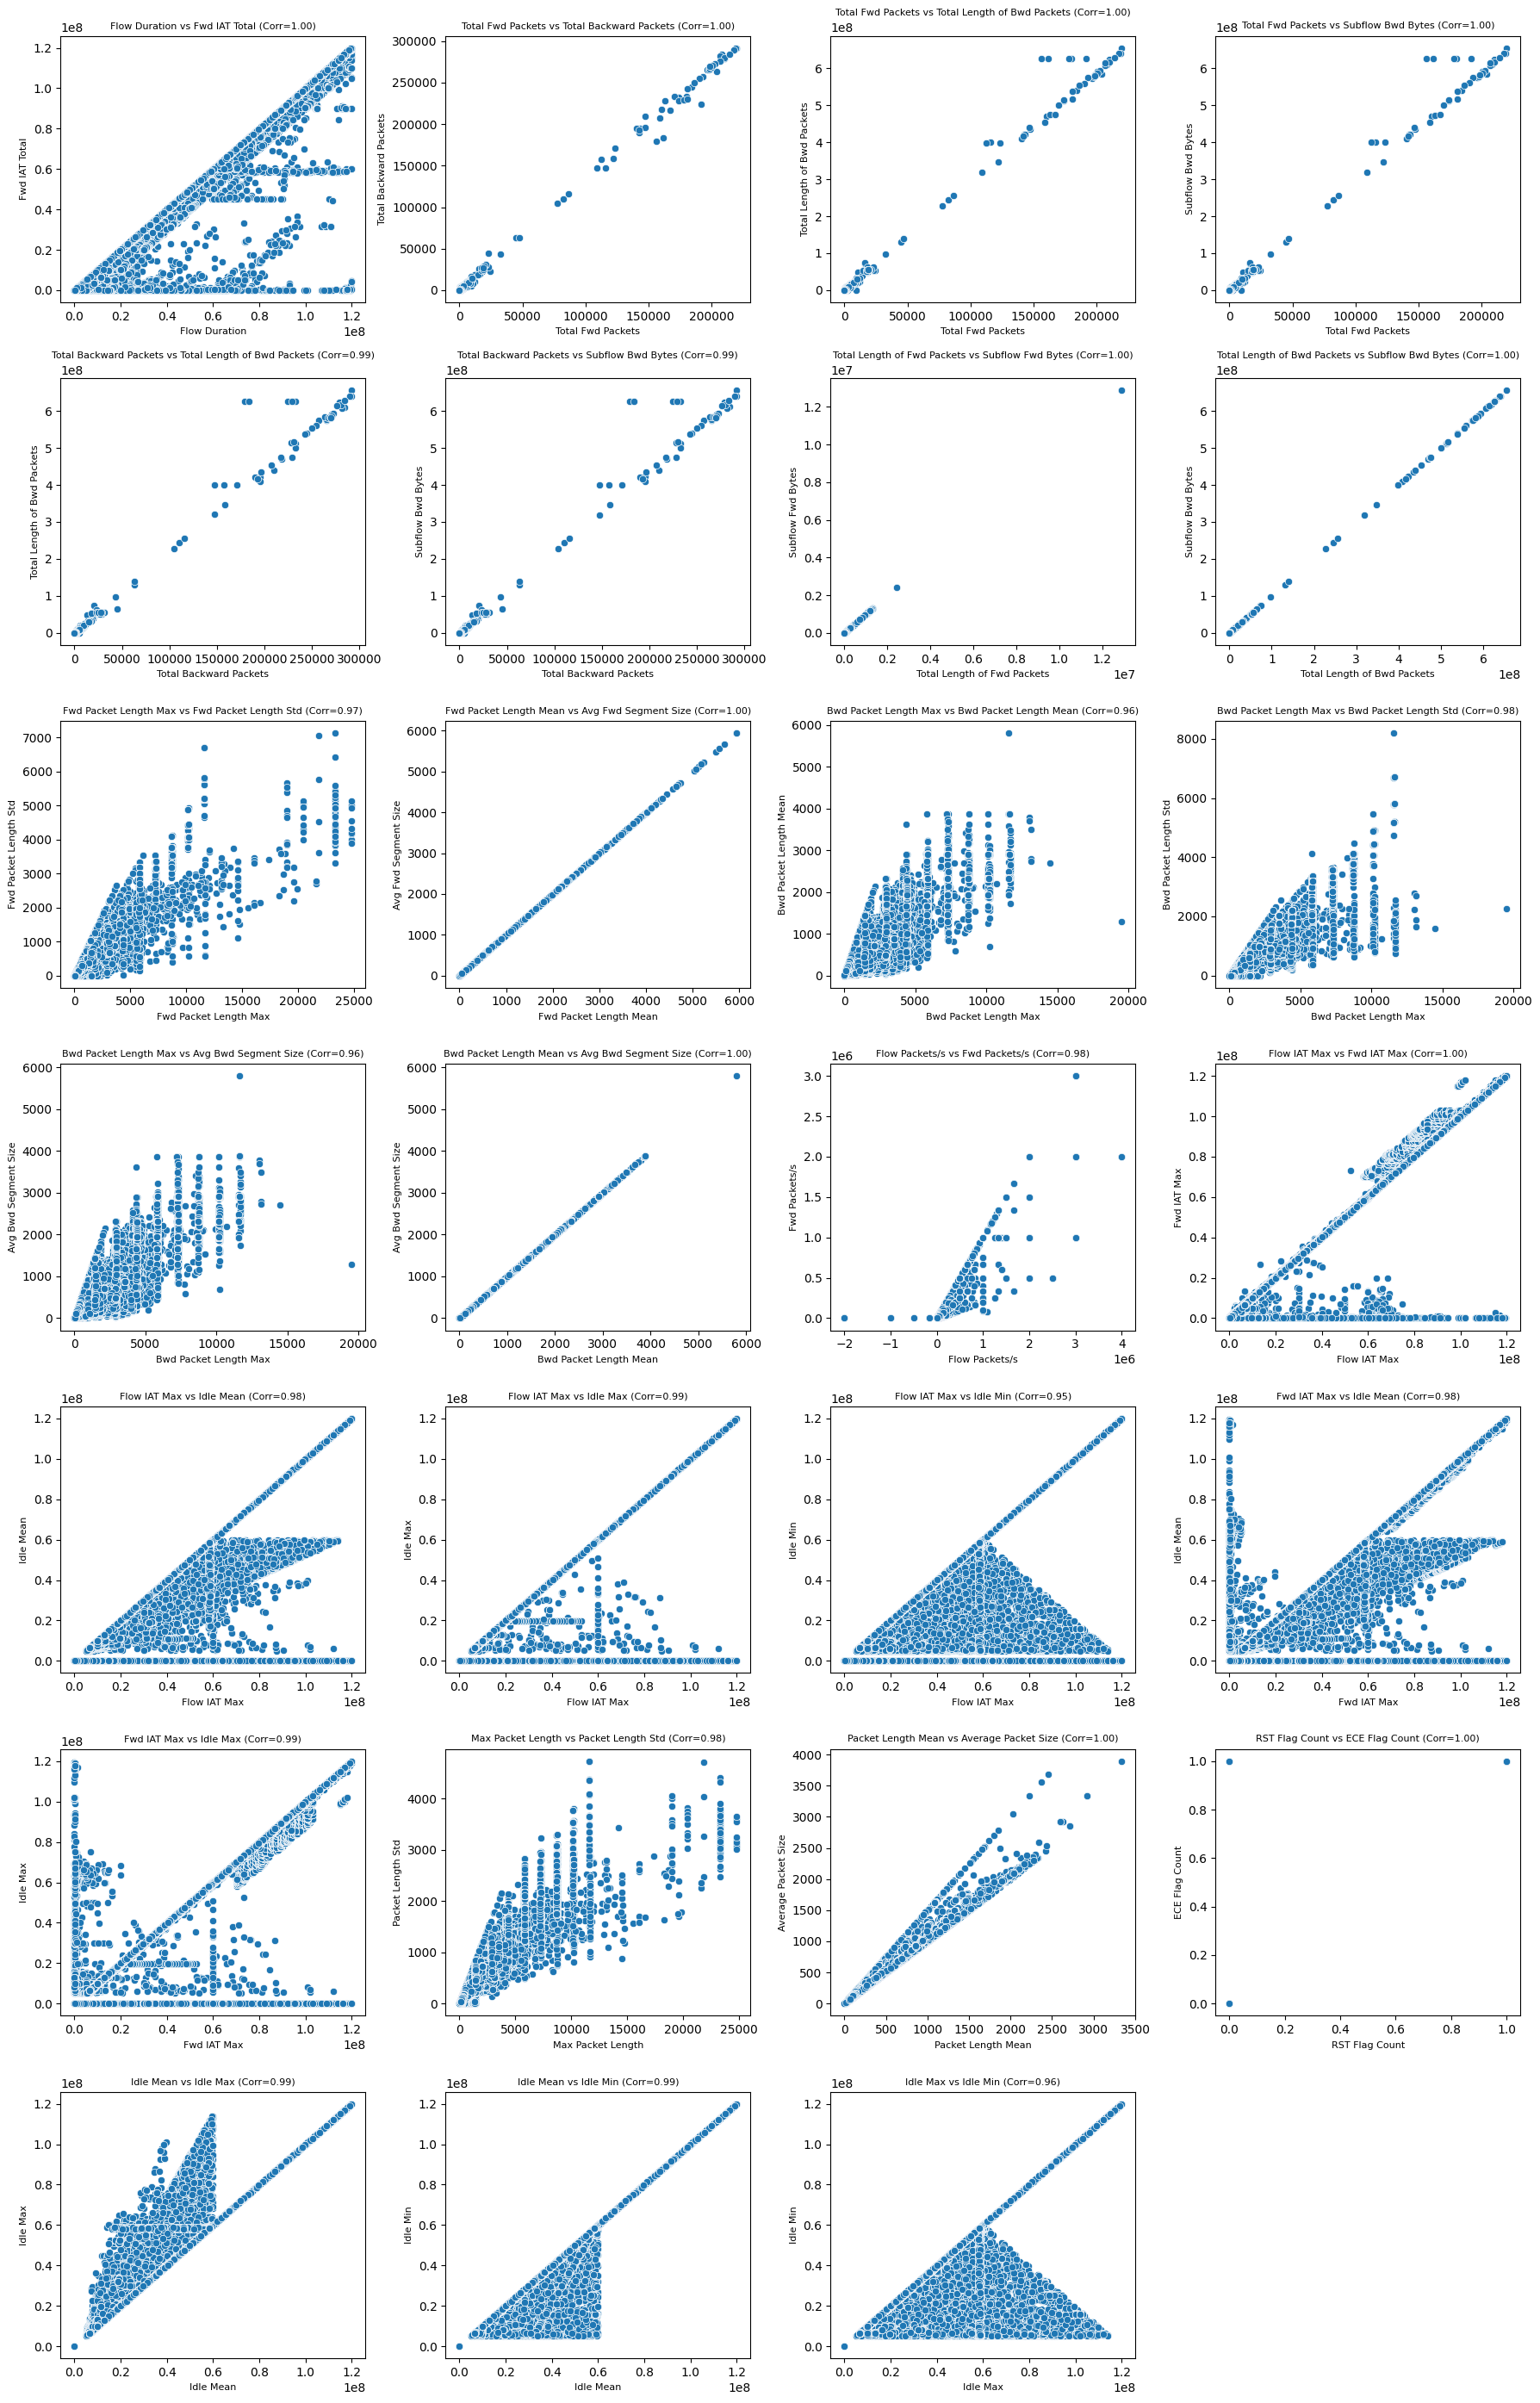

In [101]:
# Plotting the pairs with very high correlation for better visualization
n_plots = len(high_multicollinearity)
n_cols = 4
n_rows = (n_plots + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, n_rows * 4))
axes = axes.flatten()

for i, item in enumerate(high_multicollinearity):
    feature_x = item[0]
    feature_y = item[1]
    corr_value = item[2]

    # Scatter plot
    sns.scatterplot(x=df[feature_x], y=df[feature_y], ax=axes[i])
    axes[i].set_title(f'{feature_x} vs {feature_y} (Corr={corr_value:.2f})', fontsize=8)
    axes[i].set_xlabel(feature_x, fontsize=8)
    axes[i].set_ylabel(feature_y, fontsize=8)

# Hide any unused subplots
for j in range(len(high_multicollinearity), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [102]:
df.to_csv('cicids2017_before_corr_analysis.csv', index=False)

In [103]:
# Removal of columns based on correlation analysis
selected_columns = ['Total Backward Packets', 'Total Length of Bwd Packets', 'Subflow Bwd Bytes', 'Avg Fwd Segment Size', 'Avg Bwd Segment Size']

# dropping columns with perfect/near perfect multicollinearity
df.drop(columns=selected_columns, inplace=True)

In [104]:
# Updating the variables and checking dataset shape
numeric_features, categorical_features = get_feature_types(df)
df.shape

(2520751, 61)

In [ ]:
# Result of RF after droped features with high correlation
eval_dataset_w_RF(df, target_column='Attack Type')

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   20.0s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.8min finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 150 out of 150 | elapsed:    2.0s finished


Cross validation average score: 0.9854 +/- standard deviation: 0.0143
Accuracy on the test set: 0.9959
Resource measurements: {'Memory Usage (MB)': 7745.28125, 'Training Time (s)': 109.09547019004822, 'Peak CPU Usage (%)': 100.0, 'Average CPU Usage (%)': 94.58857142857143}


c:\Users\Pavel\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Pavel\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Pavel\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

                precision    recall  f1-score   support

          Bots       1.00      0.02      0.04       650
   Brute Force       1.00      0.97      0.98      3050
          DDoS       1.00      1.00      1.00     42671
           DoS       1.00      0.98      0.99     64582
Normal Traffic       1.00      1.00      1.00    698353
 Port Scanning       0.99      1.00      0.99     30231
   Web Attacks       0.00      0.00      0.00       714

      accuracy                           1.00    840251
     macro avg       0.85      0.71      0.71    840251
  weighted avg       1.00      1.00      1.00    840251



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   19.3s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.7min finished


KeyboardInterrupt: 

## Outliers

In [3]:
def calculate_outliers_percentage(df):
    outlier_percentages = {}  # empty dictionary to store outlier percentages

    for column in df.columns:
        Q1 = df[column].quantile(0.25)  # first quartile (Q1) for the column
        Q3 = df[column].quantile(0.75)  # third quartile (Q3) for the column
        IQR = Q3 - Q1  # Interquartile Range (IQR)

        lower_bound = Q1 - 1.5 * IQR  # lower bound for outliers
        upper_bound = Q3 + 1.5 * IQR  # upper bound for outliers

        # Identify outliers in the column
        outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]

        # Calculate the percentage of outliers for the column
        outlier_percentage = len(outliers) / len(df) * 100

        # Store the outlier percentage in the dictionary
        outlier_percentages[column] = outlier_percentage

    return outlier_percentages

<Figure size 1500x1000 with 0 Axes>

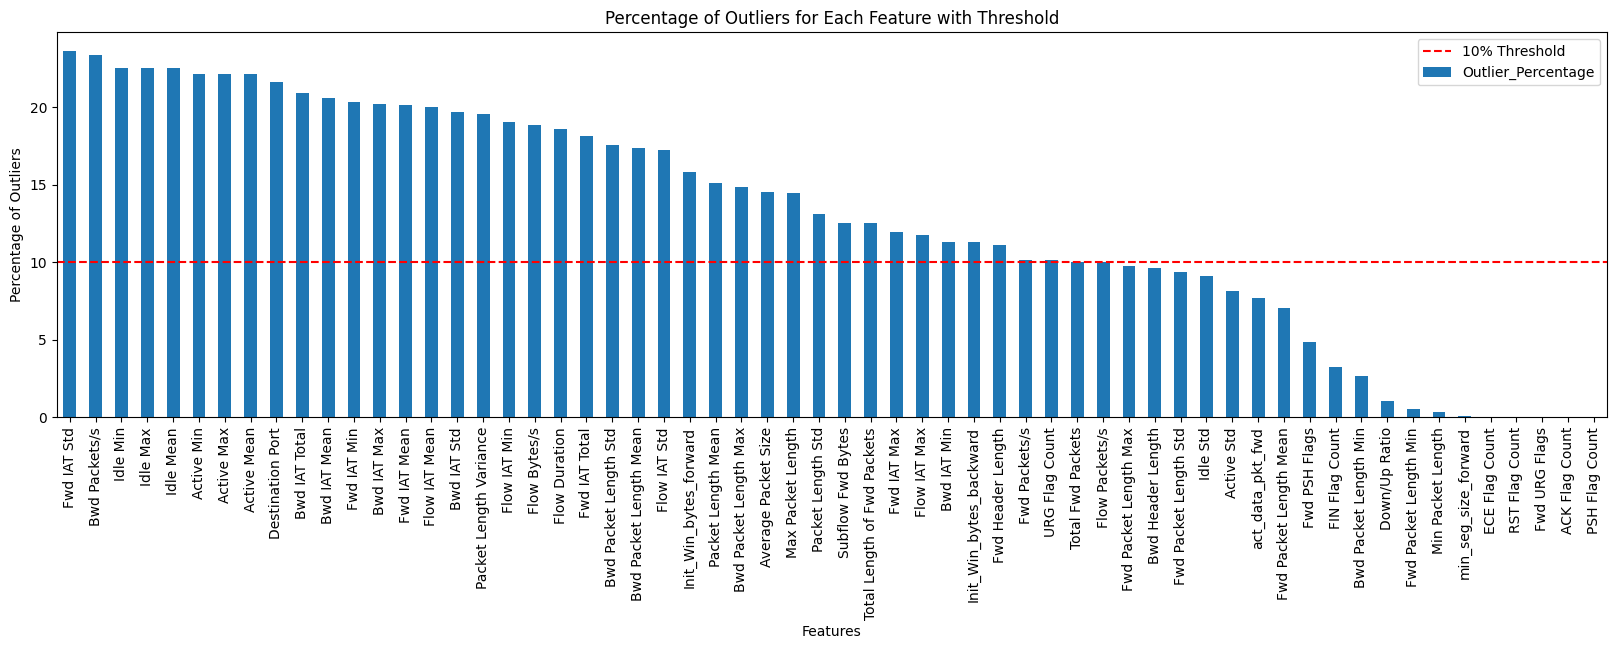

In [106]:
# Calculate outliers percentage
outlier_percentages = calculate_outliers_percentage(df[numeric_features])

# Convert to DataFrame for easier manipulation
outliers_df = pd.DataFrame.from_dict(outlier_percentages, orient='index', columns=['Outlier_Percentage'])

# Define the threshold for concern
threshold = 10

# Identify features with high percentage of outliers
high_outlier_features = outliers_df[outliers_df['Outlier_Percentage'] > threshold]

# Plot the outlier percentages and highlight features above the threshold
plt.figure(figsize=(15, 10))
outliers_df.sort_values(by='Outlier_Percentage', ascending=False).plot(kind='bar', legend=False, figsize=(20, 5))
plt.axhline(y=threshold, color='r', linestyle='--', label=f'{threshold}% Threshold')
plt.xlabel('Features')
plt.ylabel('Percentage of Outliers')
plt.title('Percentage of Outliers for Each Feature with Threshold')
plt.legend()
plt.show()

## Dtata Distribution

In [107]:
from scipy import stats

In [108]:
norm_dist = 0
not_norm_dist = 0

for col in numeric_features:

    # Perform Anderson-Darling test for normality
    result = stats.anderson(df[col], dist='norm')

    # Compare the statistic with the critical value at 5% significance level
    if result.statistic < result.critical_values[2]:  # 5% significance level
        norm_dist += 1
    else:
        not_norm_dist += 1

print(f'{norm_dist} features are normally distributed')
print(f'{not_norm_dist} features are not normally distributed')

0 features are normally distributed
60 features are not normally distributed


## Class Imbalance

In [109]:
# Count occurrences of each attack type and convert to a DataFrame
attack_counts_df = df['Attack Type'].value_counts().reset_index()
attack_counts_df.columns = ['Attack Type', 'Number of Occurrences']

# Counting the total for each attack on both cases
total_occurrences = attack_counts_df['Number of Occurrences'].sum()

# Calculating the respective percentages
attack_counts_df['% of Total'] = ((attack_counts_df['Number of Occurrences'] / total_occurrences) * 100).round(2)

print(attack_counts_df)

      Attack Type  Number of Occurrences  % of Total
0  Normal Traffic                2095057       83.11
1             DoS                 193745        7.69
2            DDoS                 128014        5.08
3   Port Scanning                  90694        3.60
4     Brute Force                   9150        0.36
5     Web Attacks                   2143        0.09
6            Bots                   1948        0.08


In [110]:
# Cleaning up
del attack_counts_df

 ## Feature importance

In [111]:
def analyze_variance_homogeneity(df, numeric_features, target_col='Attack Type'):  
    results_levene = {}  
    
    for feature in numeric_features:  
        # Group data by y and filter out groups with zero values  
        groups = [group[feature].dropna().values for name, group in df.groupby(target_col)   
                  if not group[feature].dropna().empty]  
        
        # Filter out groups that contain only zero values or have zero variance  
        groups = [group for group in groups if len(group) > 0 and np.any(group != 0) and np.var(group) > 0]  
        
        # Check if there are at least two groups with valid data  
        if len(groups) < 2:  
            print(f"Not enough valid groups to perform Levene's test for feature: {feature}")  
            continue  # Skip this feature if not enough valid groups  

        # Perform Levene's Test  
        stat_levene, p_value_levene = stats.levene(*groups)  
        results_levene[feature] = {'Statistic': stat_levene, 'p-value': p_value_levene}  

    return results_levene

In [112]:
# Applying the Levene's Test
# p-value < 0.05 suggests unequal variances among groups (rejecting the null hypothesis of equal variances)
variance_result = analyze_variance_homogeneity(df, numeric_features)

Not enough valid groups to perform Levene's test for feature: Fwd URG Flags
Not enough valid groups to perform Levene's test for feature: RST Flag Count
Not enough valid groups to perform Levene's test for feature: ECE Flag Count


In [113]:
# Analysing the results
no_significant_results = True

for feature, result in variance_result.items():   
    if result['p-value'] > 0.05:  
        print(f"\nFeature: {feature}")  
        print(f"  - Test Statistic: {result['Statistic']:.4f}")  
        print(f"  - p-value: {result['p-value']:.4f}")  
        print("  - Interpretation: The variances are not significantly different (fail to reject null hypothesis).")  
        no_significant_results = False

# If no features had p-values > 0.05  
if no_significant_results:  
    print("\nNo features have p-values greater than 0.05. All features have significant differences in variance.")


Feature: Fwd Header Length
  - Test Statistic: 0.1504
  - p-value: 0.9890
  - Interpretation: The variances are not significantly different (fail to reject null hypothesis).

Feature: Bwd Header Length
  - Test Statistic: 0.3305
  - p-value: 0.9213
  - Interpretation: The variances are not significantly different (fail to reject null hypothesis).

Feature: min_seg_size_forward
  - Test Statistic: 0.6496
  - p-value: 0.6271
  - Interpretation: The variances are not significantly different (fail to reject null hypothesis).


In [163]:
def analyze_feature_importance(df, numeric_features, target_col='Attack Type'):
    h_scores = {}  
    
    for feature in numeric_features:  
        # Group data by y and perform the Kruskal-Wallis test  
        groups = [group[feature].dropna().values for name, group in df.groupby(target_col)]  
        h_stat, p_val = stats.kruskal(*groups)  
        h_scores[feature] = {'H-statistic': h_stat, 'p-value': p_val}  

    # Create a DataFrame from the results  
    h_scores_df = pd.DataFrame.from_dict(h_scores, orient='index')  
    h_scores_df = h_scores_df.sort_values('H-statistic', ascending=False)  

    # Plotting H-statistics  
    plt.figure(figsize=(18, 10))  
    plt.bar(range(len(h_scores_df)), h_scores_df['H-statistic'], color='skyblue')  
    plt.xticks(range(len(h_scores_df)), h_scores_df.index, rotation=90)  
    plt.title('Feature Importance based on H-statistic (Kruskal-Wallis Test)')  
    plt.xlabel('Features')  
    plt.ylabel('H-statistic')  
    plt.tight_layout()  
    plt.show()  

    return h_scores_df

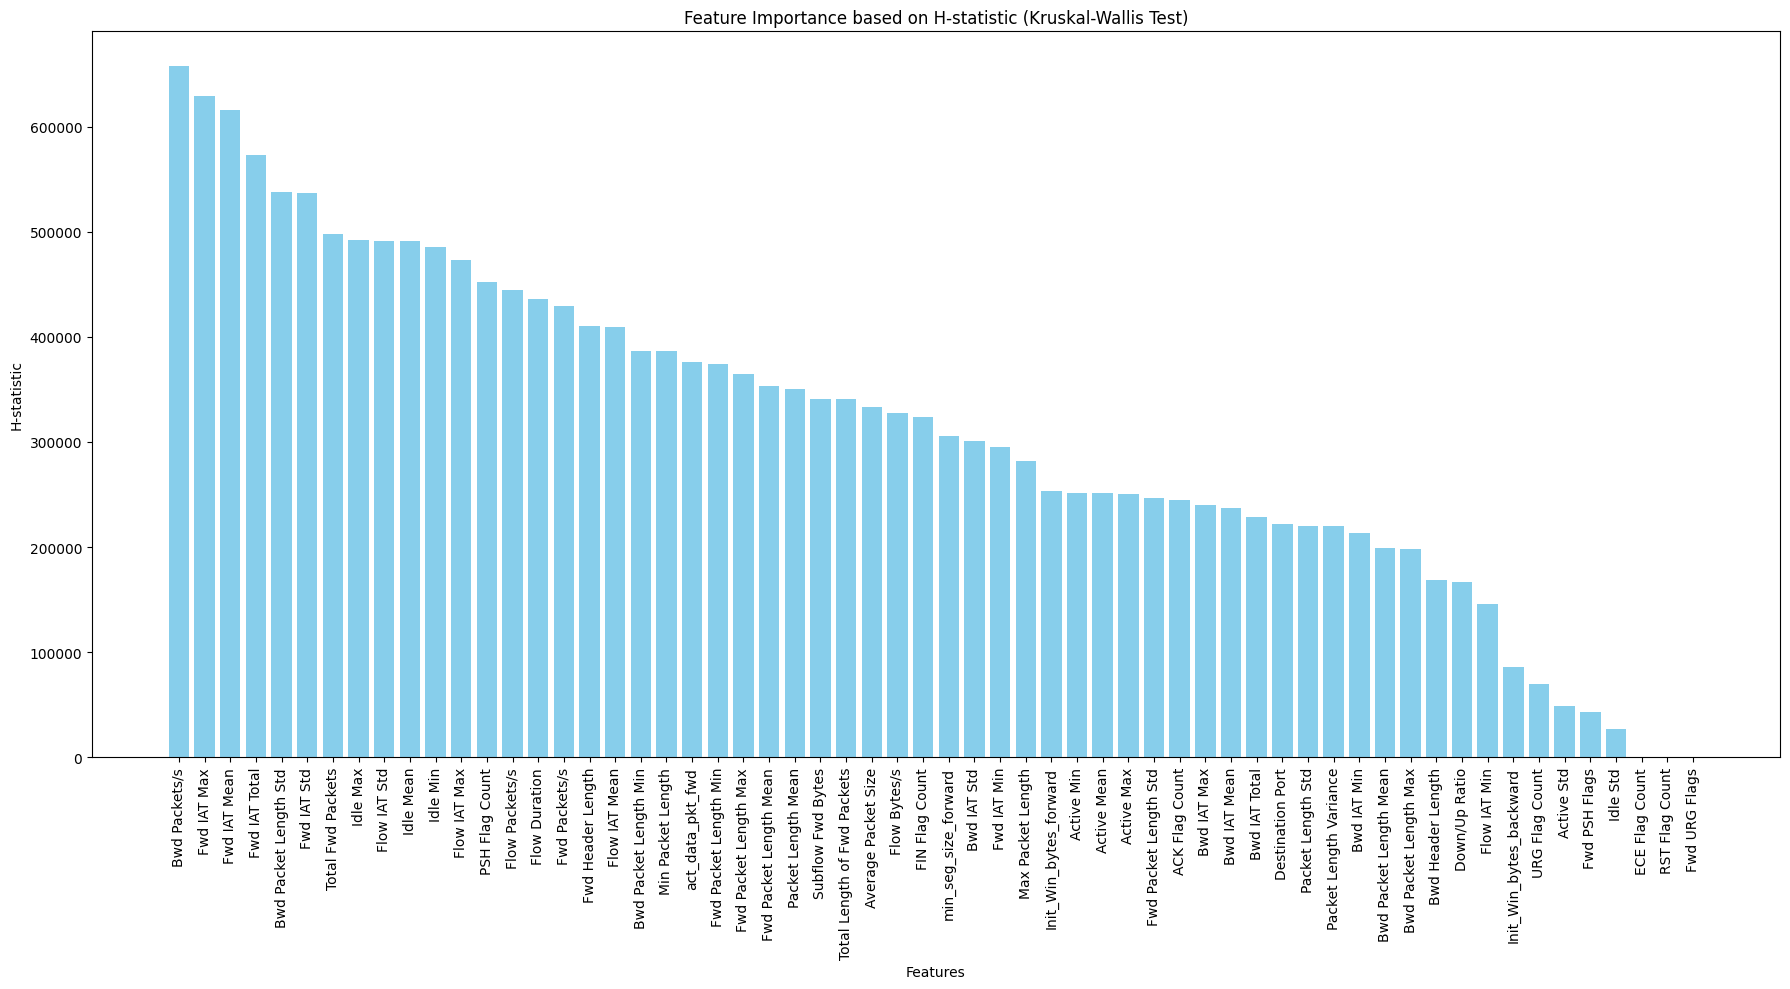

In [ ]:
h_p_stats = analyze_feature_importance(df, numeric_features)

In [164]:
def analyze_feature_importance_rf(df, numeric_features, target_col='Attack Type'):
    # Hyperparameter settings
    hyperparameters = {
        'n_estimators': 150,    # Number of trees
        'max_depth': 30,        # Limit tree depth
        'random_state': 42,     # For reproducibility
        'n_jobs': -1            # Use all available cores
    }

    # Prepare the data
    X = df[numeric_features]
    y = df[target_col]

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=hyperparameters['random_state'], stratify=y)

    # Create the Random Forest model with specified hyperparameters
    rf = RandomForestClassifier(**hyperparameters)

    # Fit the model on the training set
    rf.fit(X_train, y_train)

    # Cross-validation on the training set
    cv_scores = cross_val_score(rf, X_train, y_train, cv=5, n_jobs=-1)
    print(f'Cross-Validation Score: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}')
    
    # Predict on test set
    y_pred = rf.predict(X_test)

    # Feature importances
    importances = rf.feature_importances_
    feature_importance_df = pd.DataFrame({'Feature': numeric_features, 'Importance': importances})
    feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)

    # Confusion matrix
    rf_labels = rf.classes_
    cm = confusion_matrix(y_test, y_pred)

    # Calculate test scores
    report = classification_report(y_test, y_pred, target_names=rf_labels)
    print("\nClassification Report:\n")
    print(report, end='\n\n')

    # Plot feature importances
    plt.figure(figsize=(18, 12))
    plt.bar(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
    plt.ylabel('Importance')
    plt.xlabel('Features')
    plt.title('Feature Importance from Random Forest')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

    return feature_importance_df, cm, rf_labels, cv_scores

c:\Users\Pavel\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
3 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Pavel\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Pavel\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Pavel\AppData\L

Cross-Validation Score: nan ± nan

Classification Report:

                precision    recall  f1-score   support

          Bots       0.90      0.73      0.80       587
   Brute Force       1.00      1.00      1.00      4150
          DDoS       1.00      1.00      1.00     38407
           DoS       1.00      1.00      1.00     75514
Normal Traffic       1.00      1.00      1.00    681393
 Port Scanning       0.99      0.99      0.99     47641
   Web Attacks       1.00      0.96      0.98       654

      accuracy                           1.00    848346
     macro avg       0.98      0.95      0.97    848346
  weighted avg       1.00      1.00      1.00    848346




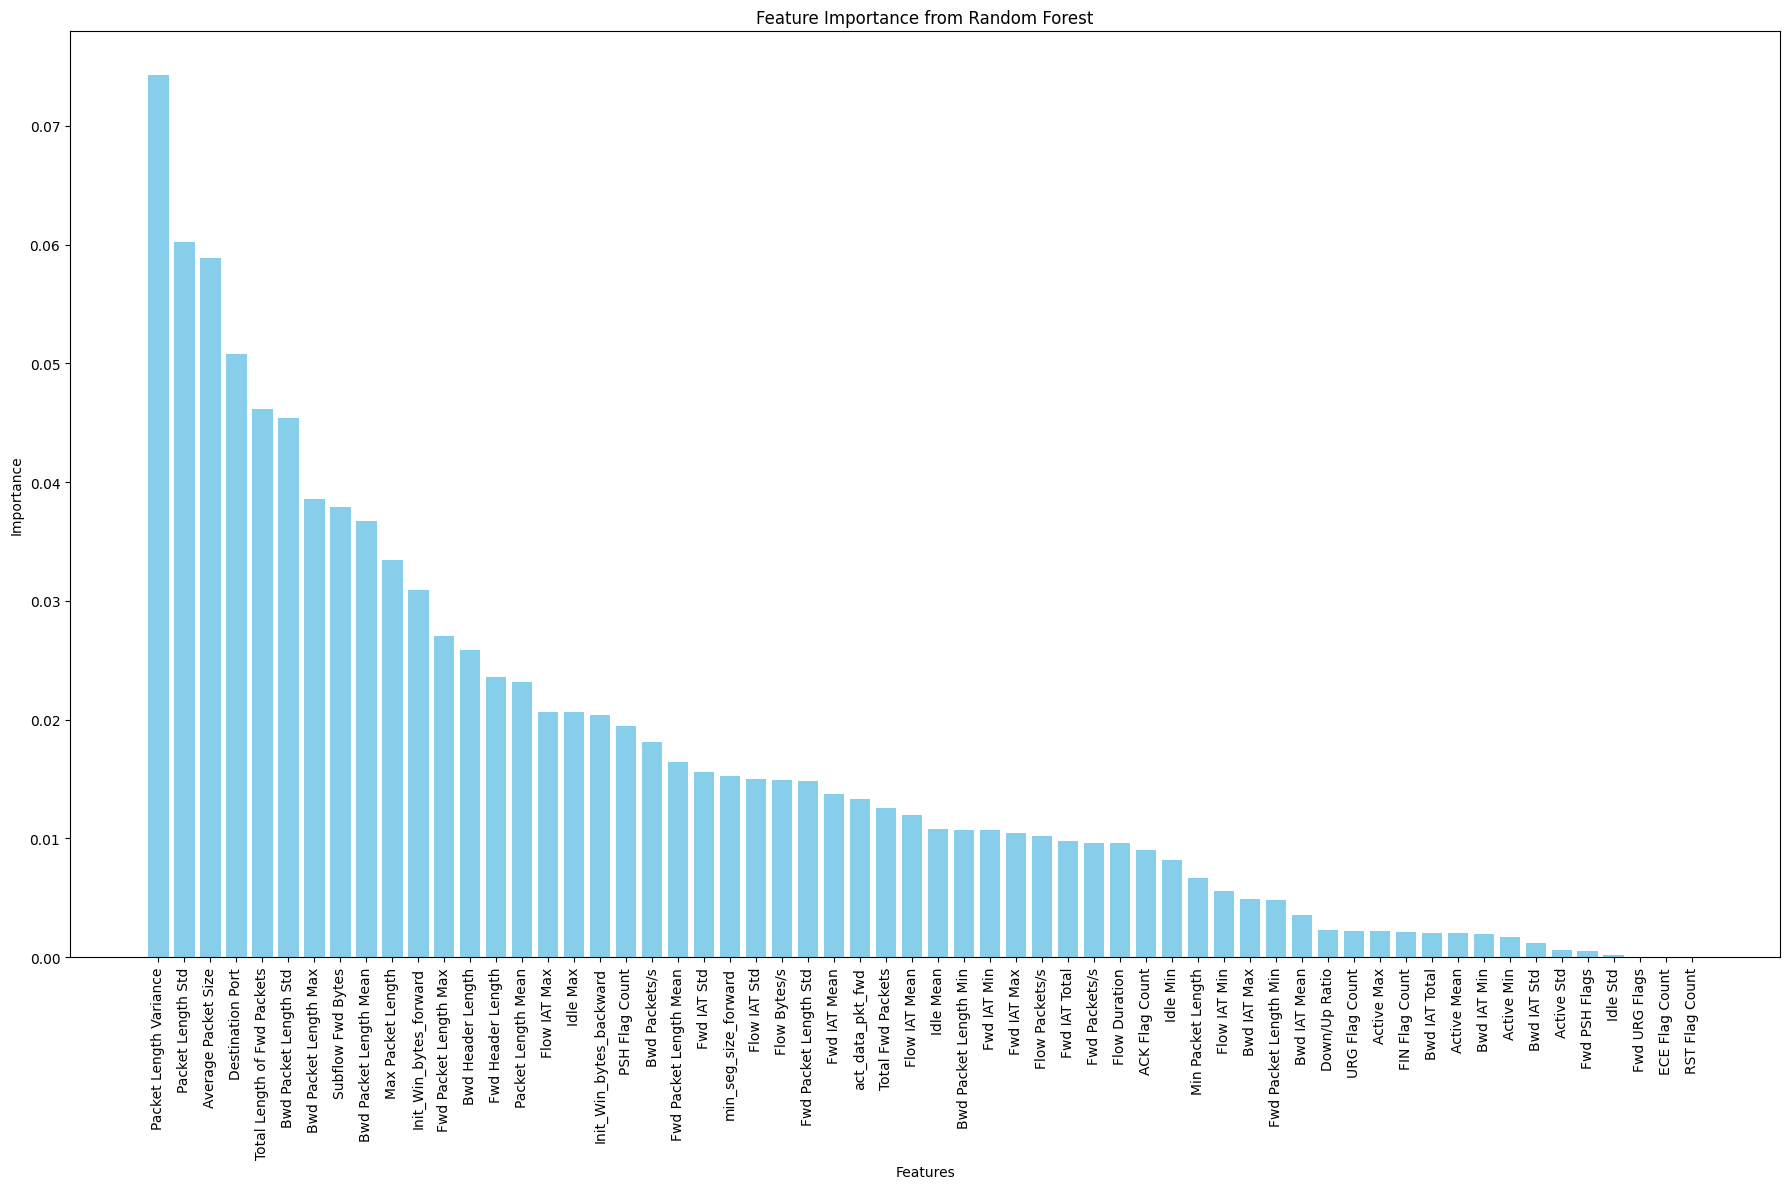

In [135]:
feature_importance_tree, cm, rf_labels, cv_scores = analyze_feature_importance_rf(df, numeric_features)

Random Forests, being ensemble methods, offer a built-in mechanism for assessing feature importance. This importance is calculated based on how much each feature contributes to decreasing impurity (e.g., Gini impurity or entropy) within the decision trees of the forest. Features used higher up in the trees or in more trees of the forest for making splits are considered more important as they contribute more significantly to the model's predictive performance.

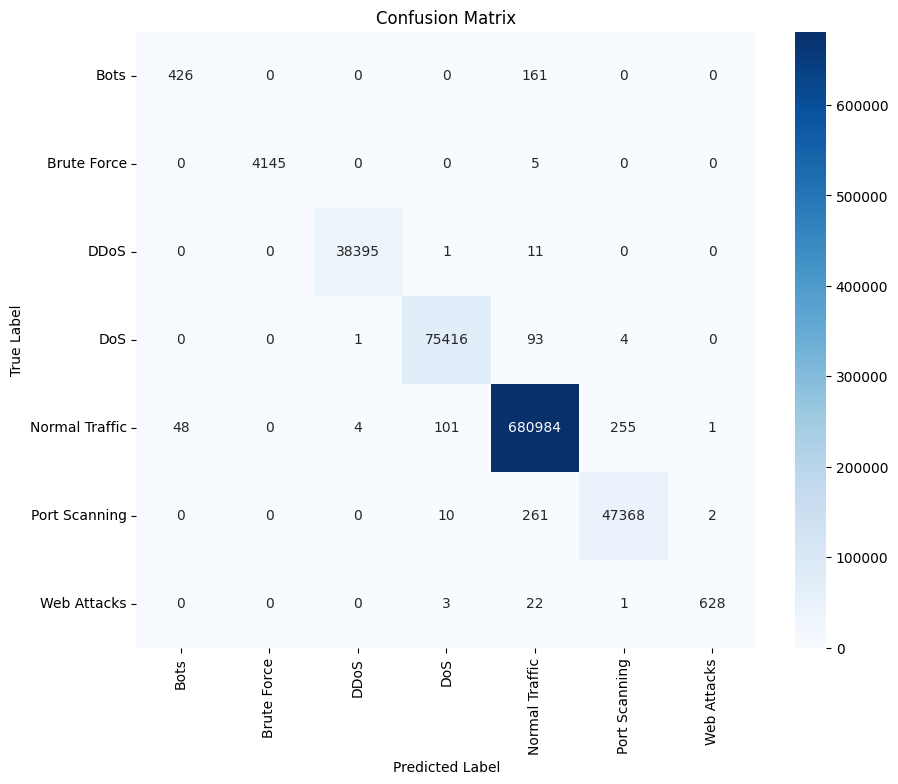

In [137]:
# Evaluating RF performance based on selected features
# Plot the confusion matrix as a heatmap
plt.figure(figsize=(10, 8)) # Adjust figure size as needed
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=rf_labels, yticklabels=rf_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

After evaluating the Random Forest model's performance, we observe an overall positive result, indicating its suitability for feature importance analysis. However, the confusion matrix and the classification report reveal a notable weakness in classifying Bot attacks, with roughly 1/4 of these instances being misclassified as normal traffic (which is not surprising, considering this is a minority class). This misclassification highlights a potential area for improvement in our final intrusion detection model, which could be explored by considering more sophisticated bot detection methods, specialized feature engineering, and data balancing techniques. Despite this limitation, the overall performance justifies using the Random Forest's feature importance scores as a valuable reference for comparison with the Kruskal-Wallis H-statistic in our subsequent feature selection process.

In [138]:
# Preparing the df for comparison
h_p_stats.reset_index(inplace = True)
h_p_stats.rename(columns = {'index':'Feature'}, inplace = True)

# Sorting the new df for easier visualization
comparison_tb = feature_importance_tree.merge(h_p_stats, on = 'Feature', how = 'left')
comparison_tb_sorted = comparison_tb.sort_values(by='Importance', ascending=False)
comparison_tb_sorted

,Feature,Importance,H-statistic,p-value
0,Packet Length Variance,7.425363e-02,220277.502527,0.000000e+00
1,Packet Length Std,6.019754e-02,220354.460435,0.000000e+00
2,Average Packet Size,5.885981e-02,333539.414140,0.000000e+00
3,Destination Port,5.077794e-02,222245.778266,0.000000e+00
4,Total Length of Fwd Packets,4.618599e-02,340874.341958,0.000000e+00
5,Bwd Packet Length Std,4.543600e-02,538239.120325,0.000000e+00
6,Bwd Packet Length Max,3.857069e-02,198505.073548,0.000000e+00
7,Subflow Fwd Bytes,3.788276e-02,340874.341958,0.000000e+00
8,Bwd Packet Length Mean,3.672073e-02,199098.911350,0.000000e+00
9,Max Packet Length,3.345012e-02,281891.003916,0.000000e+00


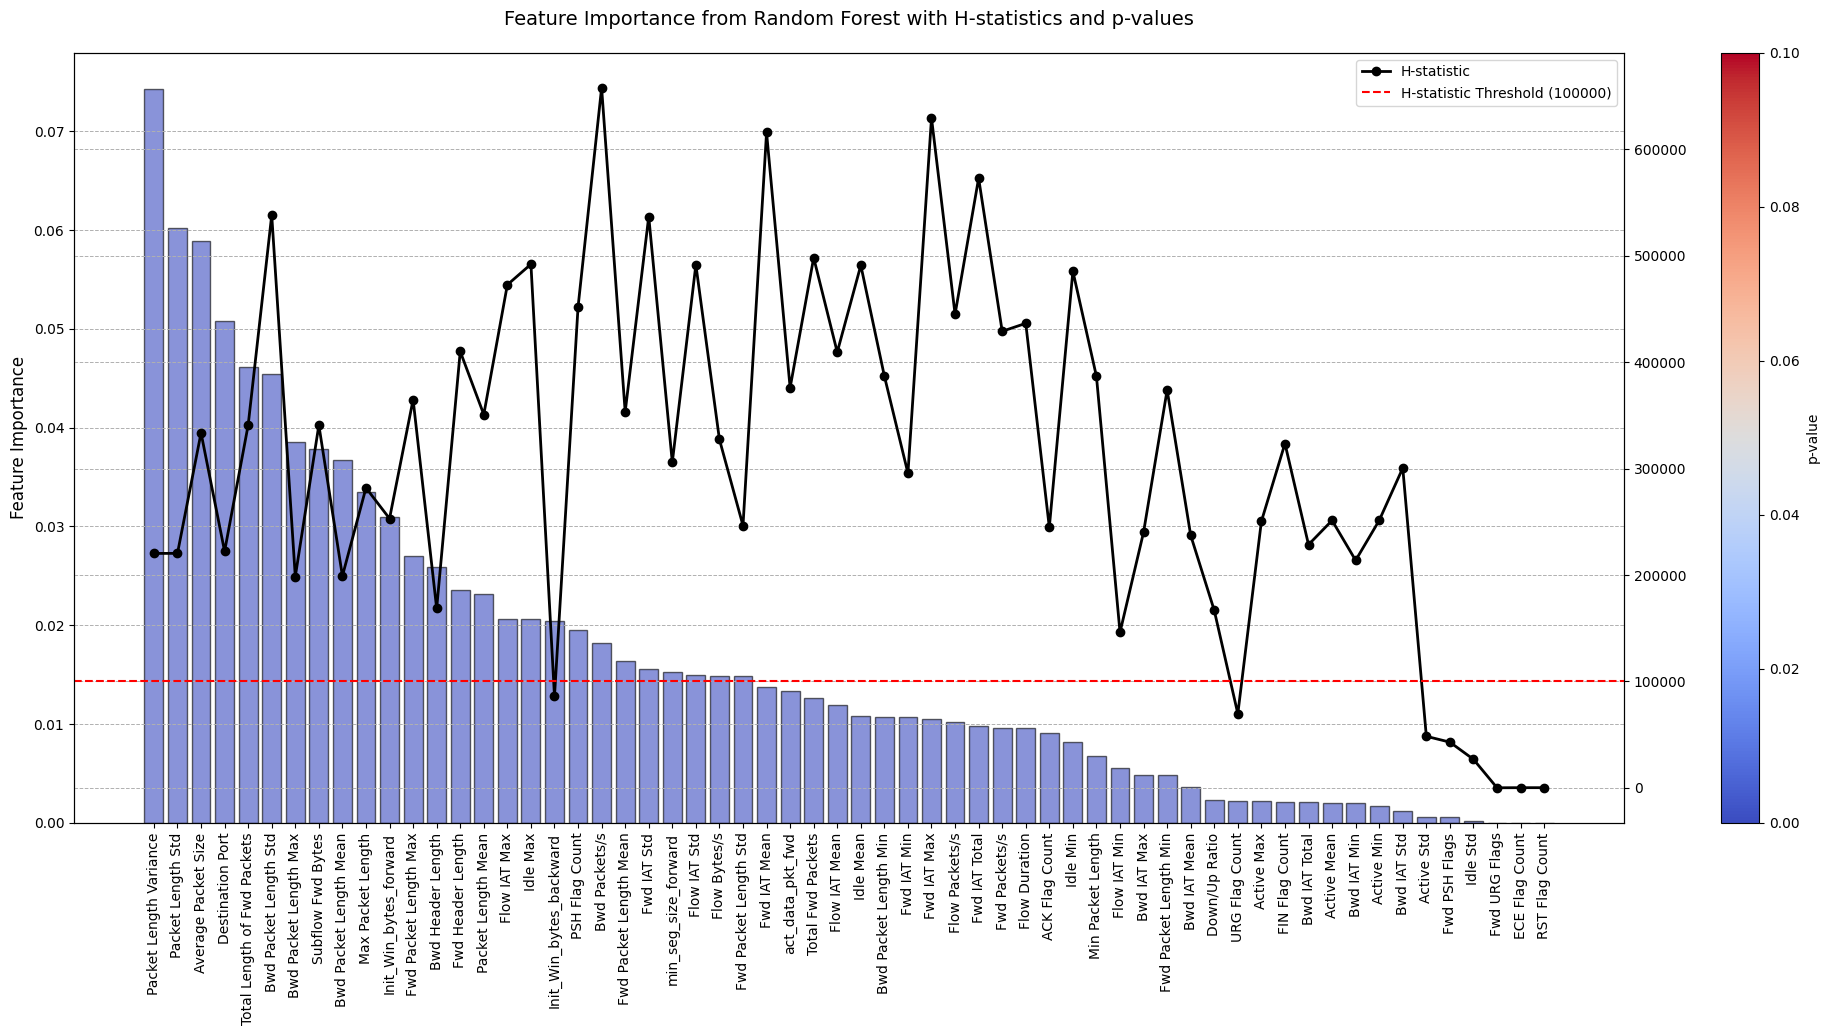

In [139]:
# Create figure and axis
plt.figure(figsize=(25, 10))

# Create a color map based on p-value
colors = sns.color_palette("coolwarm", as_cmap=True)

# Create twin axes for different scales
ax1 = plt.gca()
ax2 = ax1.twinx()

# Plot bars for importance
bars = ax1.bar(comparison_tb_sorted['Feature'],
                comparison_tb_sorted['Importance'],
                alpha=0.6,
                color=[colors(0 + (value)) for value in comparison_tb_sorted['p-value']], edgecolor='black')

# Plot line for H-statistic
line = ax2.plot(comparison_tb_sorted['Feature'],
                 comparison_tb_sorted['H-statistic'],
                 color='black',
                 linewidth=2,
                 label='H-statistic',
                 marker='o')

# Add a horizontal threshold line
threshold = 100000
ax2.axhline(y=threshold, color='red', linestyle='--', label=f'H-statistic Threshold ({threshold})')
ax2.legend()

# Customize primary y-axis (Importance)
ax1.set_ylabel('Feature Importance', fontsize=12, color='black')
ax1.tick_params(axis='y', labelcolor='black')

# Set x-ticks and labels
ax1.set_xticks(range(len(comparison_tb_sorted['Feature'])))
ax1.set_xticklabels(comparison_tb_sorted['Feature'], rotation=90, ha='center', fontsize=10)

# Add title
plt.title('Feature Importance from Random Forest with H-statistics and p-values',
          fontsize=14, pad=20)

# Add colorbar for p-values
sm = plt.cm.ScalarMappable(cmap=colors, norm=plt.Normalize(vmin=comparison_tb_sorted['p-value'].min(), vmax=0.1))
cbar = plt.colorbar(sm, ax=ax1, orientation='vertical')
cbar.set_label('p-value', fontsize=10)

# Add gridlines for readability
ax1.grid(True, which='both', axis='y', linestyle='--', linewidth=0.7)
ax2.grid(True, which='both', axis='y', linestyle='--', linewidth=0.7)

plt.show()

The plot illustrates that while some features selected by the Random Forest (RF) have lower H-statistics, the most significant features are found within the range where the highest H-statistic values are concentrated. The most interesting information, however, lies on the right tail, where there is a convergence on the lowest priority and near-zero H-statistic relevance. Based on these results, the least important features will be removed from the dataset, which helps with:

Improving Model Efficiency: Training with fewer features reduces computational cost (time and memory).
Reducing Noise: Removing irrelevant features can sometimes improve model performance by reducing noise and preventing overfitting.
Simplifying Interpretation: Models with fewer features are often easier to interpret and explain.

In [114]:
# Removing statiscally irrelavant features from the dataset
cols_to_remove = ['ECE Flag Count', 'RST Flag Count', 'Fwd URG Flags', 'Idle Std', 'Fwd PSH Flags', 'Active Std', 'Down/Up Ratio', 'URG Flag Count']
df.drop(columns=cols_to_remove, inplace=True)

In [121]:
df.shape

(2520751, 53)

In [120]:
eval_dataset_w_RF(df, target_column='Attack Type')

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   53.6s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  4.8min finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 150 out of 150 | elapsed:    2.8s finished


Cross validation average score: 0.9959 +/- standard deviation: 0.0001
Accuracy on the test set: 0.9960
Resource measurements: {'Memory Usage (MB)': 8762.09765625, 'Training Time (s)': 289.0957872867584, 'Peak CPU Usage (%)': 100.0, 'Average CPU Usage (%)': 94.97178861788618}


c:\Users\Pavel\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Pavel\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                precision    recall  f1-score   support

          Bots       1.00      0.01      0.03       584
   Brute Force       1.00      0.97      0.98      2745
          DDoS       1.00      1.00      1.00     38404
           DoS       1.00      0.98      0.99     58124
Normal Traffic       1.00      1.00      1.00    628518
 Port Scanning       0.99      1.00      0.99     27208
   Web Attacks       0.00      0.00      0.00       643

      accuracy                           1.00    756226
     macro avg       0.85      0.71      0.71    756226
  weighted avg       1.00      1.00      1.00    756226



c:\Users\Pavel\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [116]:
df.to_csv('cicids2017_FeatSelected.csv', index=False)

# Further Feature selection 

In [141]:
df = pd.read_csv('cicids2017_FeatSelected.csv', engine='python')

In [142]:
df.shape

(2520751, 53)

In [143]:
# let's remove every feature that is less or near 0.02 on importance chart and check correlation and results of eval again
columns_left = ["Attack Type", "Packet Length Variance", "Packet Length Std", "Average Packet Size", "Destination Port", "Total Length of Fwd Packets", "Bwd Packet Length Std", "Bwd Packet Length Max", "Subflow Fwd Bytes", "Bwd Packet Length Mean", 
"Max Packet Length", "Init_Win_bytes_forward", "Fwd Packet Length Max", "Bwd Header Length", "Fwd Header Length", "Packet Length Mean", "Flow IAT Max", "Idle Max", "Init_Win_bytes_backward", "PSH Flag Count", "Bwd Packets/s", "Fwd Packet Length Mean"]
len(columns_left)

22

In [144]:
for column in df.columns:
    if column not in columns_left:
        df.drop(columns=column, inplace=True)
df.shape

(2520751, 22)

In [146]:
eval_dataset_w_RF(df, target_column='Attack Type')

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   22.7s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  2.0min finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 150 out of 150 | elapsed:    2.5s finished


Cross validation average score: 0.9960 +/- standard deviation: 0.0001
Accuracy on the test set: 0.9961
Resource measurements: {'Memory Usage (MB)': 3879.296875, 'Training Time (s)': 120.04729127883911, 'Peak CPU Usage (%)': 100.0, 'Average CPU Usage (%)': 95.25676056338028}


c:\Users\Pavel\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Pavel\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                precision    recall  f1-score   support

          Bots       1.00      0.02      0.03       584
   Brute Force       1.00      0.97      0.99      2745
          DDoS       1.00      1.00      1.00     38404
           DoS       1.00      0.98      0.99     58124
Normal Traffic       1.00      1.00      1.00    628518
 Port Scanning       0.99      1.00      0.99     27208
   Web Attacks       0.00      0.00      0.00       643

      accuracy                           1.00    756226
     macro avg       0.85      0.71      0.71    756226
  weighted avg       1.00      1.00      1.00    756226



c:\Users\Pavel\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


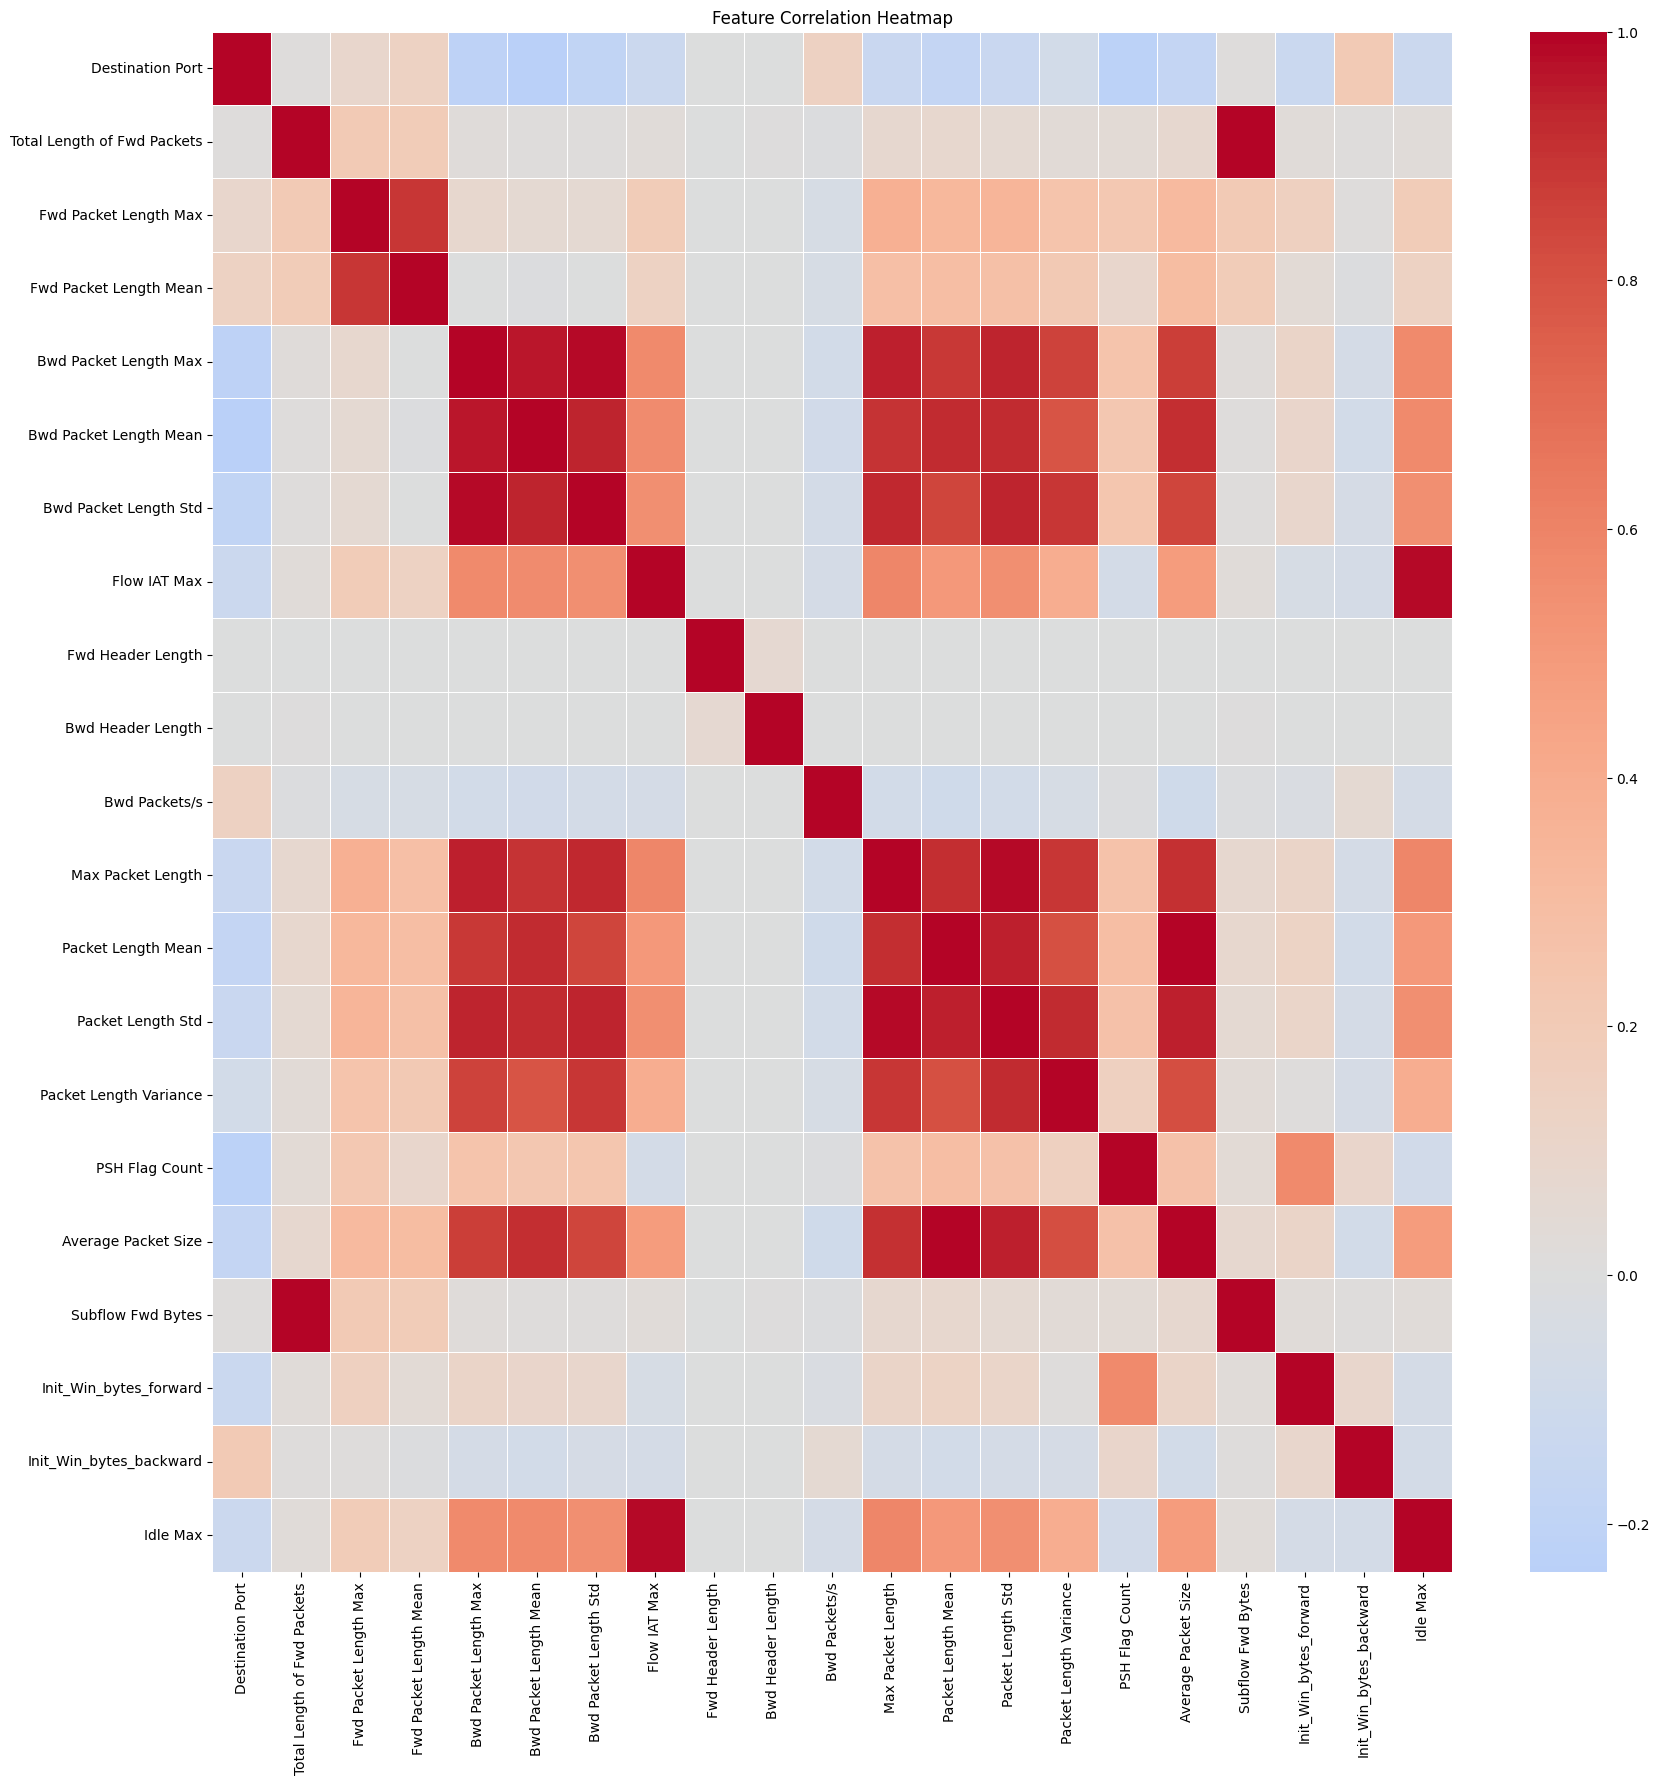

Total Length of Fwd Packets has a high correlation with Subflow Fwd Bytes: 1.0
Fwd Packet Length Max has a high correlation with Fwd Packet Length Mean: 0.889
Bwd Packet Length Max has a high correlation with Bwd Packet Length Mean: 0.9582
Bwd Packet Length Max has a high correlation with Bwd Packet Length Std: 0.9826
Bwd Packet Length Max has a high correlation with Max Packet Length: 0.9472
Bwd Packet Length Max has a high correlation with Packet Length Mean: 0.879
Bwd Packet Length Max has a high correlation with Packet Length Std: 0.9387
Bwd Packet Length Max has a high correlation with Packet Length Variance: 0.852
Bwd Packet Length Max has a high correlation with Average Packet Size: 0.874
Bwd Packet Length Mean has a high correlation with Bwd Packet Length Std: 0.9408
Bwd Packet Length Mean has a high correlation with Max Packet Length: 0.9031
Bwd Packet Length Mean has a high correlation with Packet Length Mean: 0.9209
Bwd Packet Length Mean has a high correlation with Packet L

In [147]:
numeric_features, categorical_features = get_feature_types(df)
high_corr = correlation_analysis(df, numeric_features)
high_multicollinearity = []
for item in high_corr:
    if item[0] == item[1]:
        continue
    print(f'{item[0]} has a high correlation with {item[1]}: {item[2].round(4)}')
    if item[2] >= 0.95:
        high_multicollinearity.append(item)

In [148]:
df.shape

(2520751, 22)

In [149]:
df.to_csv('cicids2017_21Feat.csv', index=False)

In [152]:
df = pd.read_csv('cicids2017_21Feat.csv', engine='python')

In [153]:
drop_columns = ["Subflow Fwd Bytes", "Idle Max", "Average Packet Size", "Packet Length Std"]
df.drop(columns=drop_columns, inplace=True)
df.shape

(2520751, 18)

In [154]:
eval_dataset_w_RF(df, target_column='Attack Type')

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   24.3s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  2.0min finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 150 out of 150 | elapsed:    2.5s finished


Cross validation average score: 0.9962 +/- standard deviation: 0.0001
Accuracy on the test set: 0.9964
Resource measurements: {'Memory Usage (MB)': 3336.515625, 'Training Time (s)': 122.79211640357971, 'Peak CPU Usage (%)': 100.0, 'Average CPU Usage (%)': 94.76917510853835}
                precision    recall  f1-score   support

          Bots       1.00      0.30      0.47       584
   Brute Force       1.00      0.97      0.99      2745
          DDoS       1.00      1.00      1.00     38404
           DoS       1.00      0.98      0.99     58124
Normal Traffic       1.00      1.00      1.00    628518
 Port Scanning       0.99      1.00      0.99     27208
   Web Attacks       1.00      0.01      0.01       643

      accuracy                           1.00    756226
     macro avg       1.00      0.75      0.78    756226
  weighted avg       1.00      1.00      1.00    756226



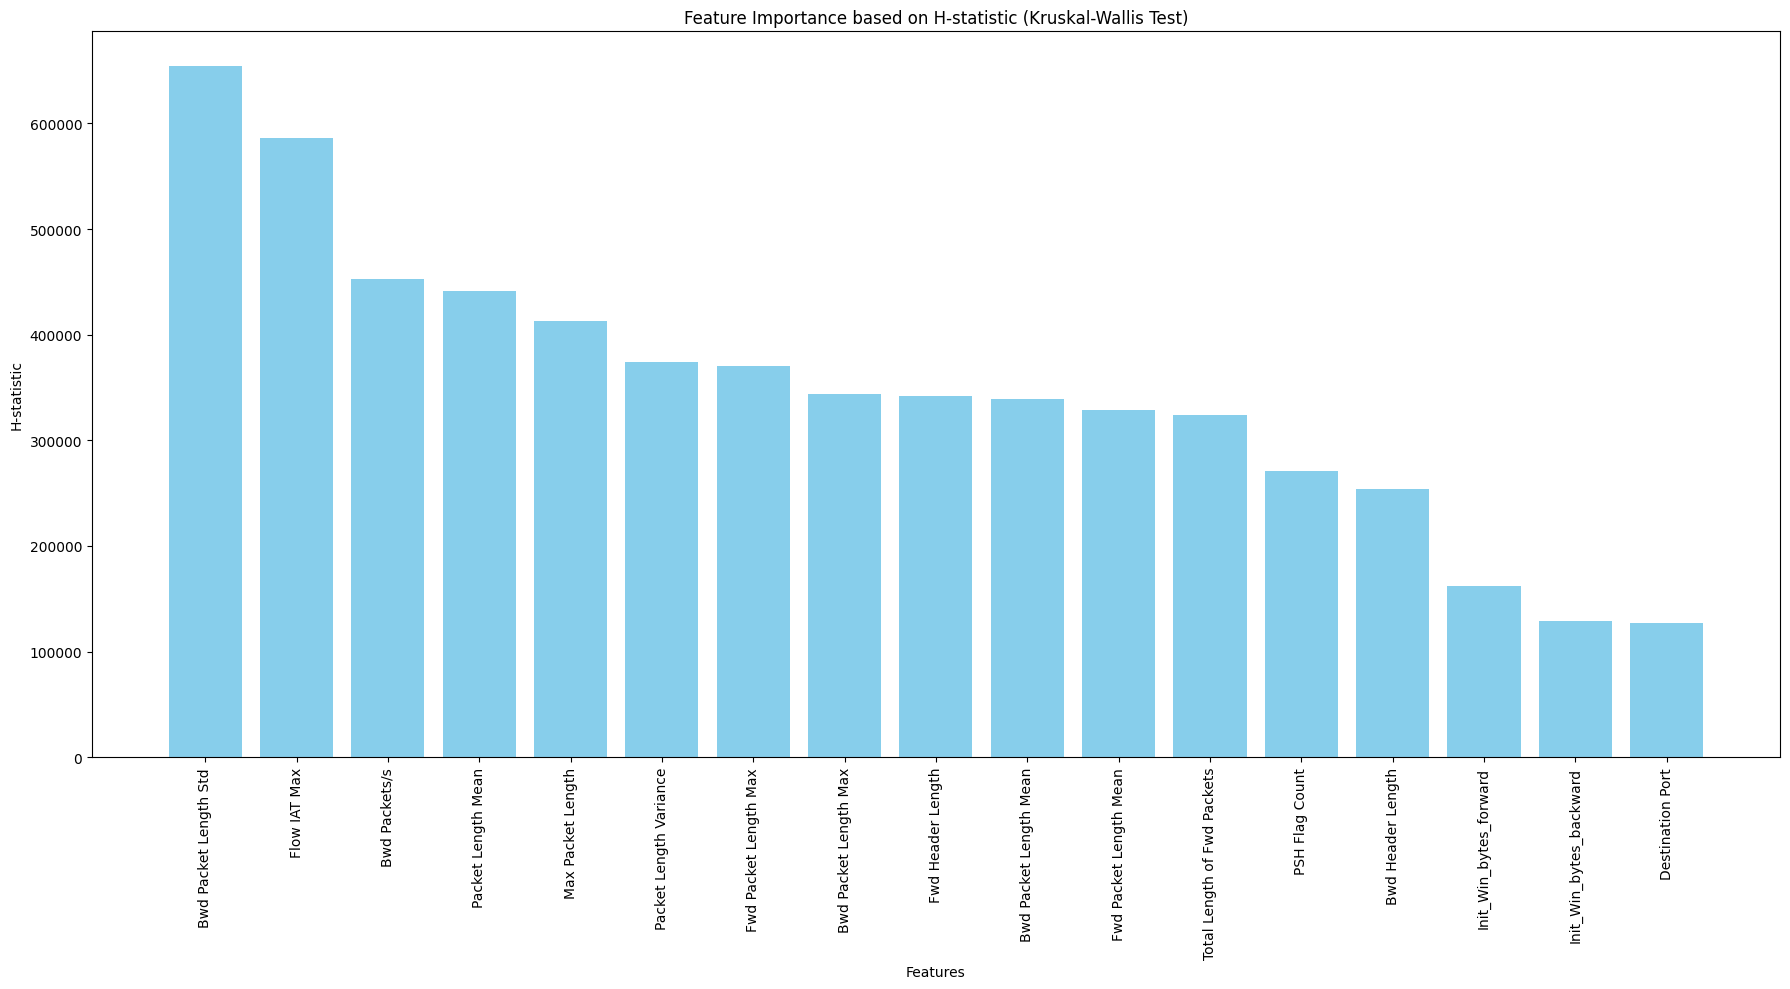

In [165]:
numeric_features, categorical_features = get_feature_types(df)
h_p_stats = analyze_feature_importance(df, numeric_features)

Cross-Validation Score: 0.9982 ± 0.0000

Classification Report:

                precision    recall  f1-score   support

          Bots       0.84      0.77      0.80       584
   Brute Force       1.00      1.00      1.00      2745
          DDoS       1.00      1.00      1.00     38404
           DoS       1.00      1.00      1.00     58124
Normal Traffic       1.00      1.00      1.00    628518
 Port Scanning       0.99      0.99      0.99     27208
   Web Attacks       0.99      0.36      0.53       643

      accuracy                           1.00    756226
     macro avg       0.97      0.87      0.90    756226
  weighted avg       1.00      1.00      1.00    756226




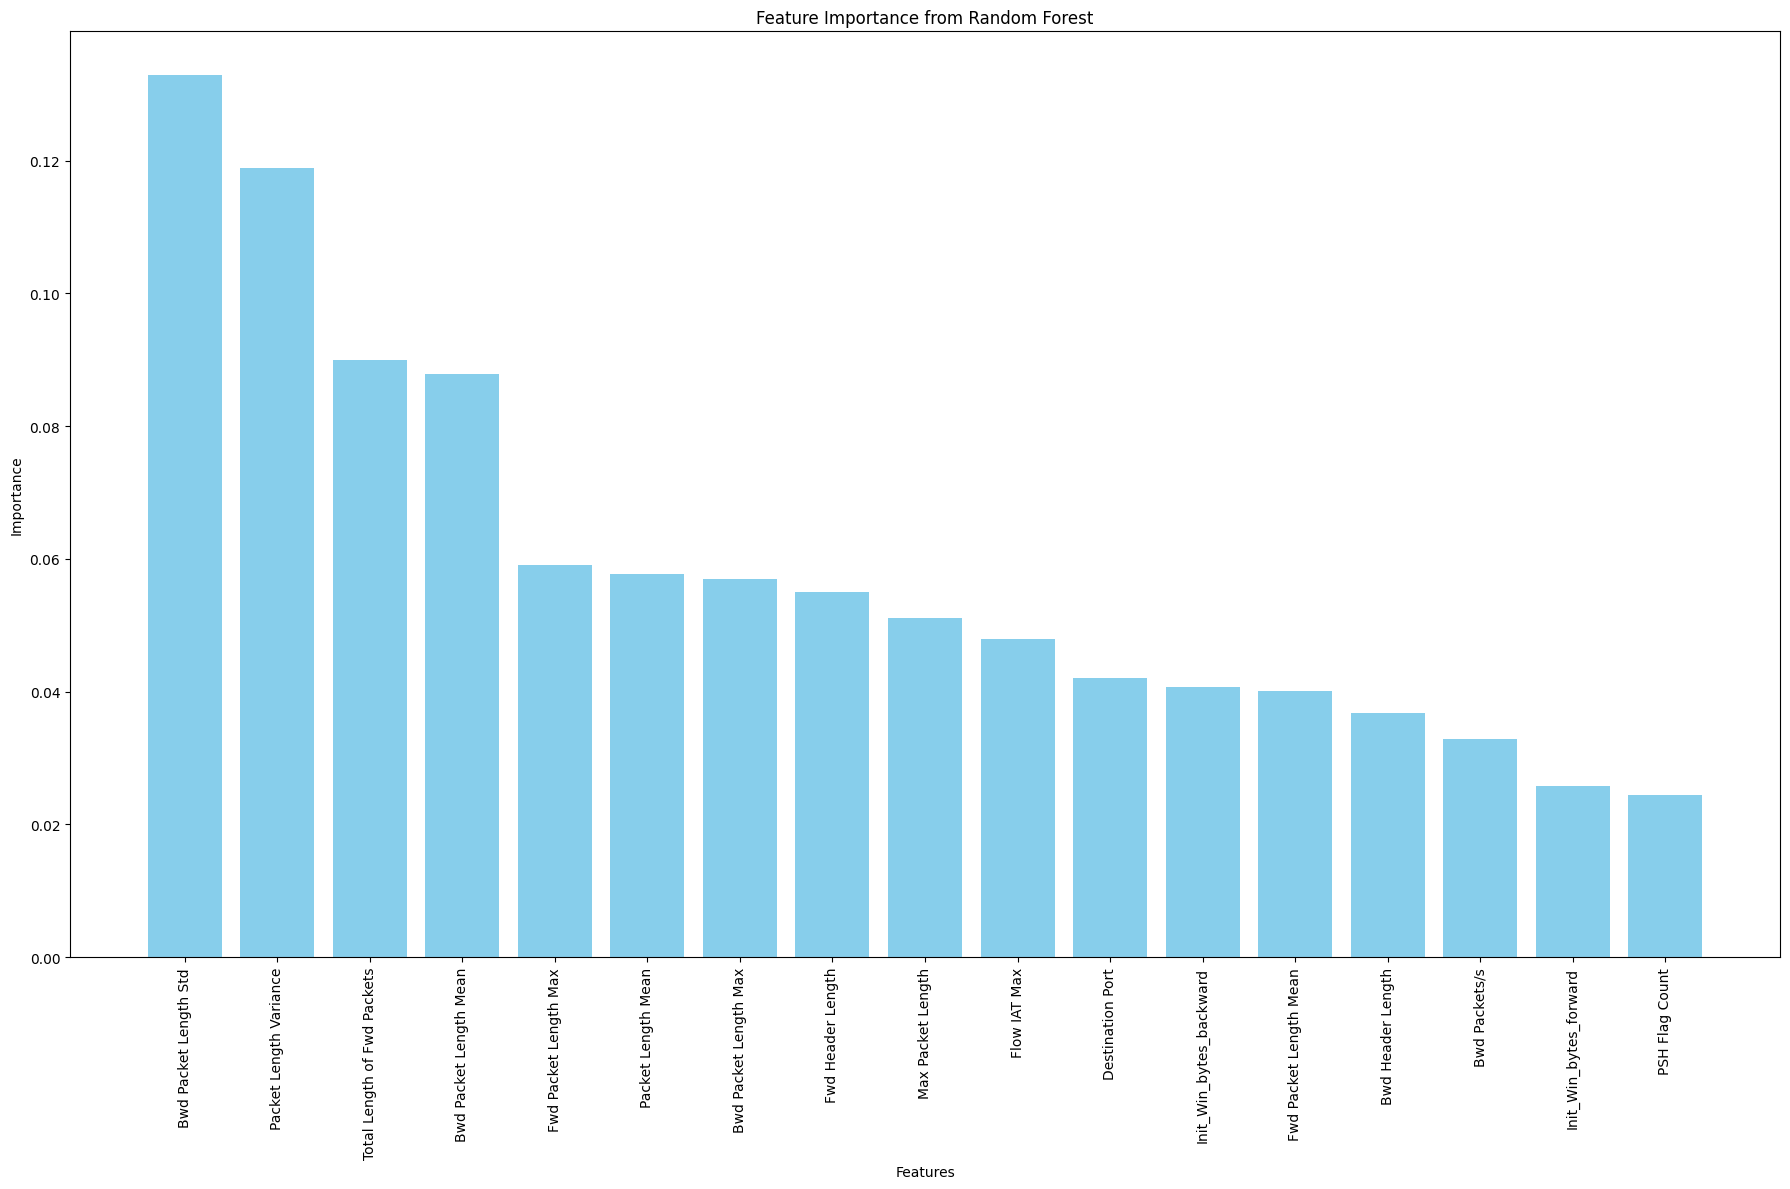

In [166]:
feature_importance_tree, cm, rf_labels, cv_scores = analyze_feature_importance_rf(df, numeric_features)

In [167]:
df.to_csv('cicids2017_final.csv', index=False)

In [169]:
df.shape

(2520751, 18)

In [170]:
df_selected = pd.read_csv('cicids2017_FeatSelected.csv', engine='python')

In [ ]:
def plot_learning_curves_comparison(df_final, df_selected, target_column='Attack Type'):
    # Prepare data for both datasets
    X_final = df_final.drop(target_column, axis=1)
    y_final = df_final[target_column]
    
    X_selected = df_selected.drop(target_column, axis=1)
    y_selected = df_selected[target_column]
    
    # Initialize RF model with your parameters
    params_rf = {
        'n_estimators': 150, 
        'min_samples_split': 5, 
        'min_samples_leaf': 2, 
        'max_features': 'sqrt', 
        'max_depth': 10,
        'random_state': 42
    }
    rf = RandomForestClassifier(**params_rf)
    
    # Generate learning curves for both datasets
    train_sizes = np.linspace(0.1, 1.0, 10)
    
    # Final dataset curves
    train_sizes_final, train_scores_final, val_scores_final = learning_curve(
        rf, X_final, y_final,
        train_sizes=train_sizes,
        cv=5,
        n_jobs=-1,
        scoring='accuracy'
    )
    
    # Selected features dataset curves
    train_sizes_selected, train_scores_selected, val_scores_selected = learning_curve(
        rf, X_selected, y_selected,
        train_sizes=train_sizes,
        cv=5,
        n_jobs=-1,
        scoring='accuracy'
    )
    
    # Plotting
    plt.figure(figsize=(12, 6))
    
    # Plot final dataset curves
    plt.plot(train_sizes_final, np.mean(train_scores_final, axis=1), 
             label=f'Train (All Features: {X_final.shape[1]})', color='blue')
    plt.plot(train_sizes_final, np.mean(val_scores_final, axis=1), 
             label=f'Validation (All Features: {X_final.shape[1]})', color='blue', linestyle='--')
    
    # Plot selected features curves
    plt.plot(train_sizes_selected, np.mean(train_scores_selected, axis=1), 
             label=f'Train (Selected Features: {X_selected.shape[1]})', color='red')
    plt.plot(train_sizes_selected, np.mean(val_scores_selected, axis=1), 
             label=f'Validation (Selected Features: {X_selected.shape[1]})', color='red', linestyle='--')
    
    plt.xlabel('Training Examples')
    plt.ylabel('Accuracy Score')
    plt.title('Learning Curves Comparison: All Features vs Selected Features')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

# To evaluate stability across different train-test splits:
def compare_stability(df_final, df_selected, target_column='Attack Type', n_iterations=10):
    params_rf = {
        'n_estimators': 150, 
        'min_samples_split': 5, 
        'min_samples_leaf': 2, 
        'max_features': 'sqrt', 
        'max_depth': 10,
        'random_state': 42
    }
    
    results = {'final': [], 'selected': []}
    
    for dataset_name, df in [('final', df_final), ('selected', df_selected)]:
        X = df.drop(target_column, axis=1)
        y = df[target_column]
        
        for i in range(n_iterations):
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=i)
            
            rf = RandomForestClassifier(**params_rf)
            rf.fit(X_train, y_train)
            
            accuracy = accuracy_score(y_test, rf.predict(X_test))
            results[dataset_name].append(accuracy)
    
    # Print stability results
    print("Stability Analysis Results:")
    print(f"Full Dataset - Mean Accuracy: {np.mean(results['final']):.4f} ± {np.std(results['final']):.4f}")
    print(f"Selected Features - Mean Accuracy: {np.mean(results['selected']):.4f} ± {np.std(results['selected']):.4f}")
    
    # Plot stability comparison
    plt.figure(figsize=(10, 6))
    plt.boxplot([results['final'], results['selected']], labels=['Full Dataset', 'Selected Features'])
    plt.title('Model Stability Comparison')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.show()

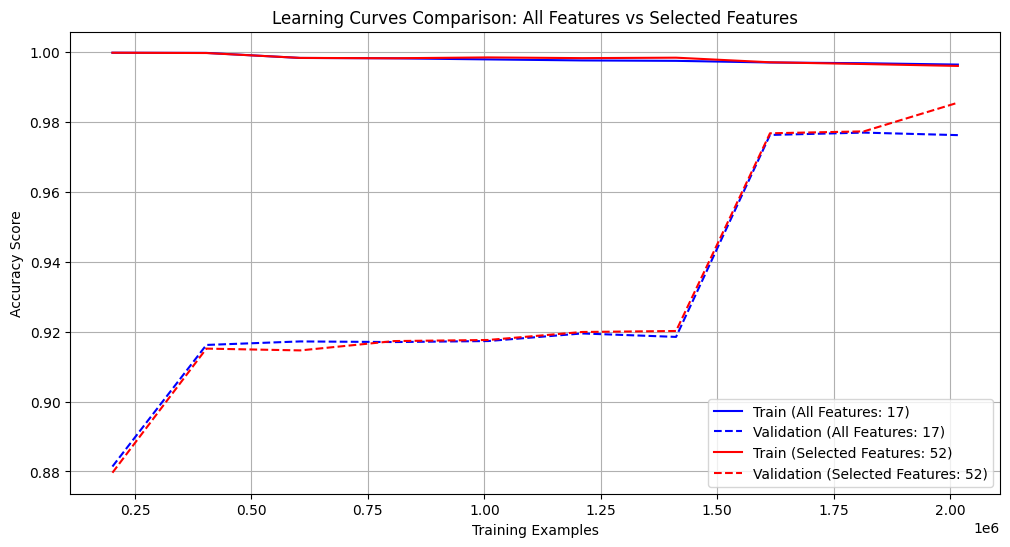

In [175]:
plot_learning_curves_comparison(df, df_selected)

Stability Analysis Results:
Full Dataset - Mean Accuracy: 0.9963 ± 0.0001
Selected Features - Mean Accuracy: 0.9959 ± 0.0000


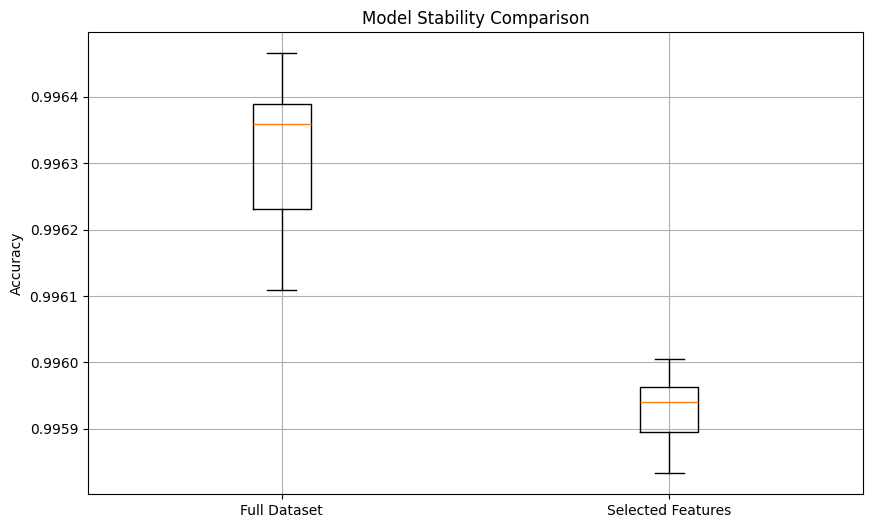

In [176]:
compare_stability(df, df_selected)

In [4]:
df = pd.read_csv('cicids2017_final.csv')

In [5]:
df.columns

Index(['Destination Port', 'Total Length of Fwd Packets',
       'Fwd Packet Length Max', 'Fwd Packet Length Mean',
       'Bwd Packet Length Max', 'Bwd Packet Length Mean',
       'Bwd Packet Length Std', 'Flow IAT Max', 'Fwd Header Length',
       'Bwd Header Length', 'Bwd Packets/s', 'Max Packet Length',
       'Packet Length Mean', 'Packet Length Variance', 'PSH Flag Count',
       'Init_Win_bytes_forward', 'Init_Win_bytes_backward', 'Attack Type'],
      dtype='object')

In [7]:
df.drop(columns=['Destination Port'], inplace=True)

In [8]:
df.columns

Index(['Total Length of Fwd Packets', 'Fwd Packet Length Max',
       'Fwd Packet Length Mean', 'Bwd Packet Length Max',
       'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow IAT Max',
       'Fwd Header Length', 'Bwd Header Length', 'Bwd Packets/s',
       'Max Packet Length', 'Packet Length Mean', 'Packet Length Variance',
       'PSH Flag Count', 'Init_Win_bytes_forward', 'Init_Win_bytes_backward',
       'Attack Type'],
      dtype='object')

In [9]:
df.shape

(2520751, 17)

In [10]:
df.to_csv("cicids2017_final_no_dst_port.csv", index=False)

In [11]:
df["Attack Type"].unique()

array(['Normal Traffic', 'DDoS', 'Port Scanning', 'Bots', 'Web Attacks',
       'Brute Force', 'DoS'], dtype=object)

In [12]:
df_full = pd.read_csv('cicids2017_before_corr_analysis.csv')

In [13]:
df_full.columns

Index(['Destination Port', 'Flow Duration', 'Total Fwd Packets',
       'Total Backward Packets', 'Total Length of Fwd Packets',
       'Total Length of Bwd Packets', 'Fwd Packet Length Max',
       'Fwd Packet Length Min', 'Fwd Packet Length Mean',
       'Fwd Packet Length Std', 'Bwd Packet Length Max',
       'Bwd Packet Length Min', 'Bwd Packet Length Mean',
       'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s',
       'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min',
       'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max',
       'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std',
       'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Fwd URG Flags',
       'Fwd Header Length', 'Bwd Header Length', 'Fwd Packets/s',
       'Bwd Packets/s', 'Min Packet Length', 'Max Packet Length',
       'Packet Length Mean', 'Packet Length Std', 'Packet Length Variance',
       'FIN Flag Count', 'RST Flag Count', 'PSH Flag Count', 'ACK Flag Count',

In [14]:
columns_to_add = ['Flow Duration', 'Total Fwd Packets', 'Total Backward Packets', 'Flow Bytes/s', 'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std', 'Bwd IAT Min', 'Bwd IAT Std', 'ACK Flag Count', 'min_seg_size_forward', 'Idle Min']

In [17]:
df_combined = df.copy()

In [18]:
df_combined[columns_to_add] = df_full[columns_to_add]

In [19]:
df_combined.shape

(2520751, 29)

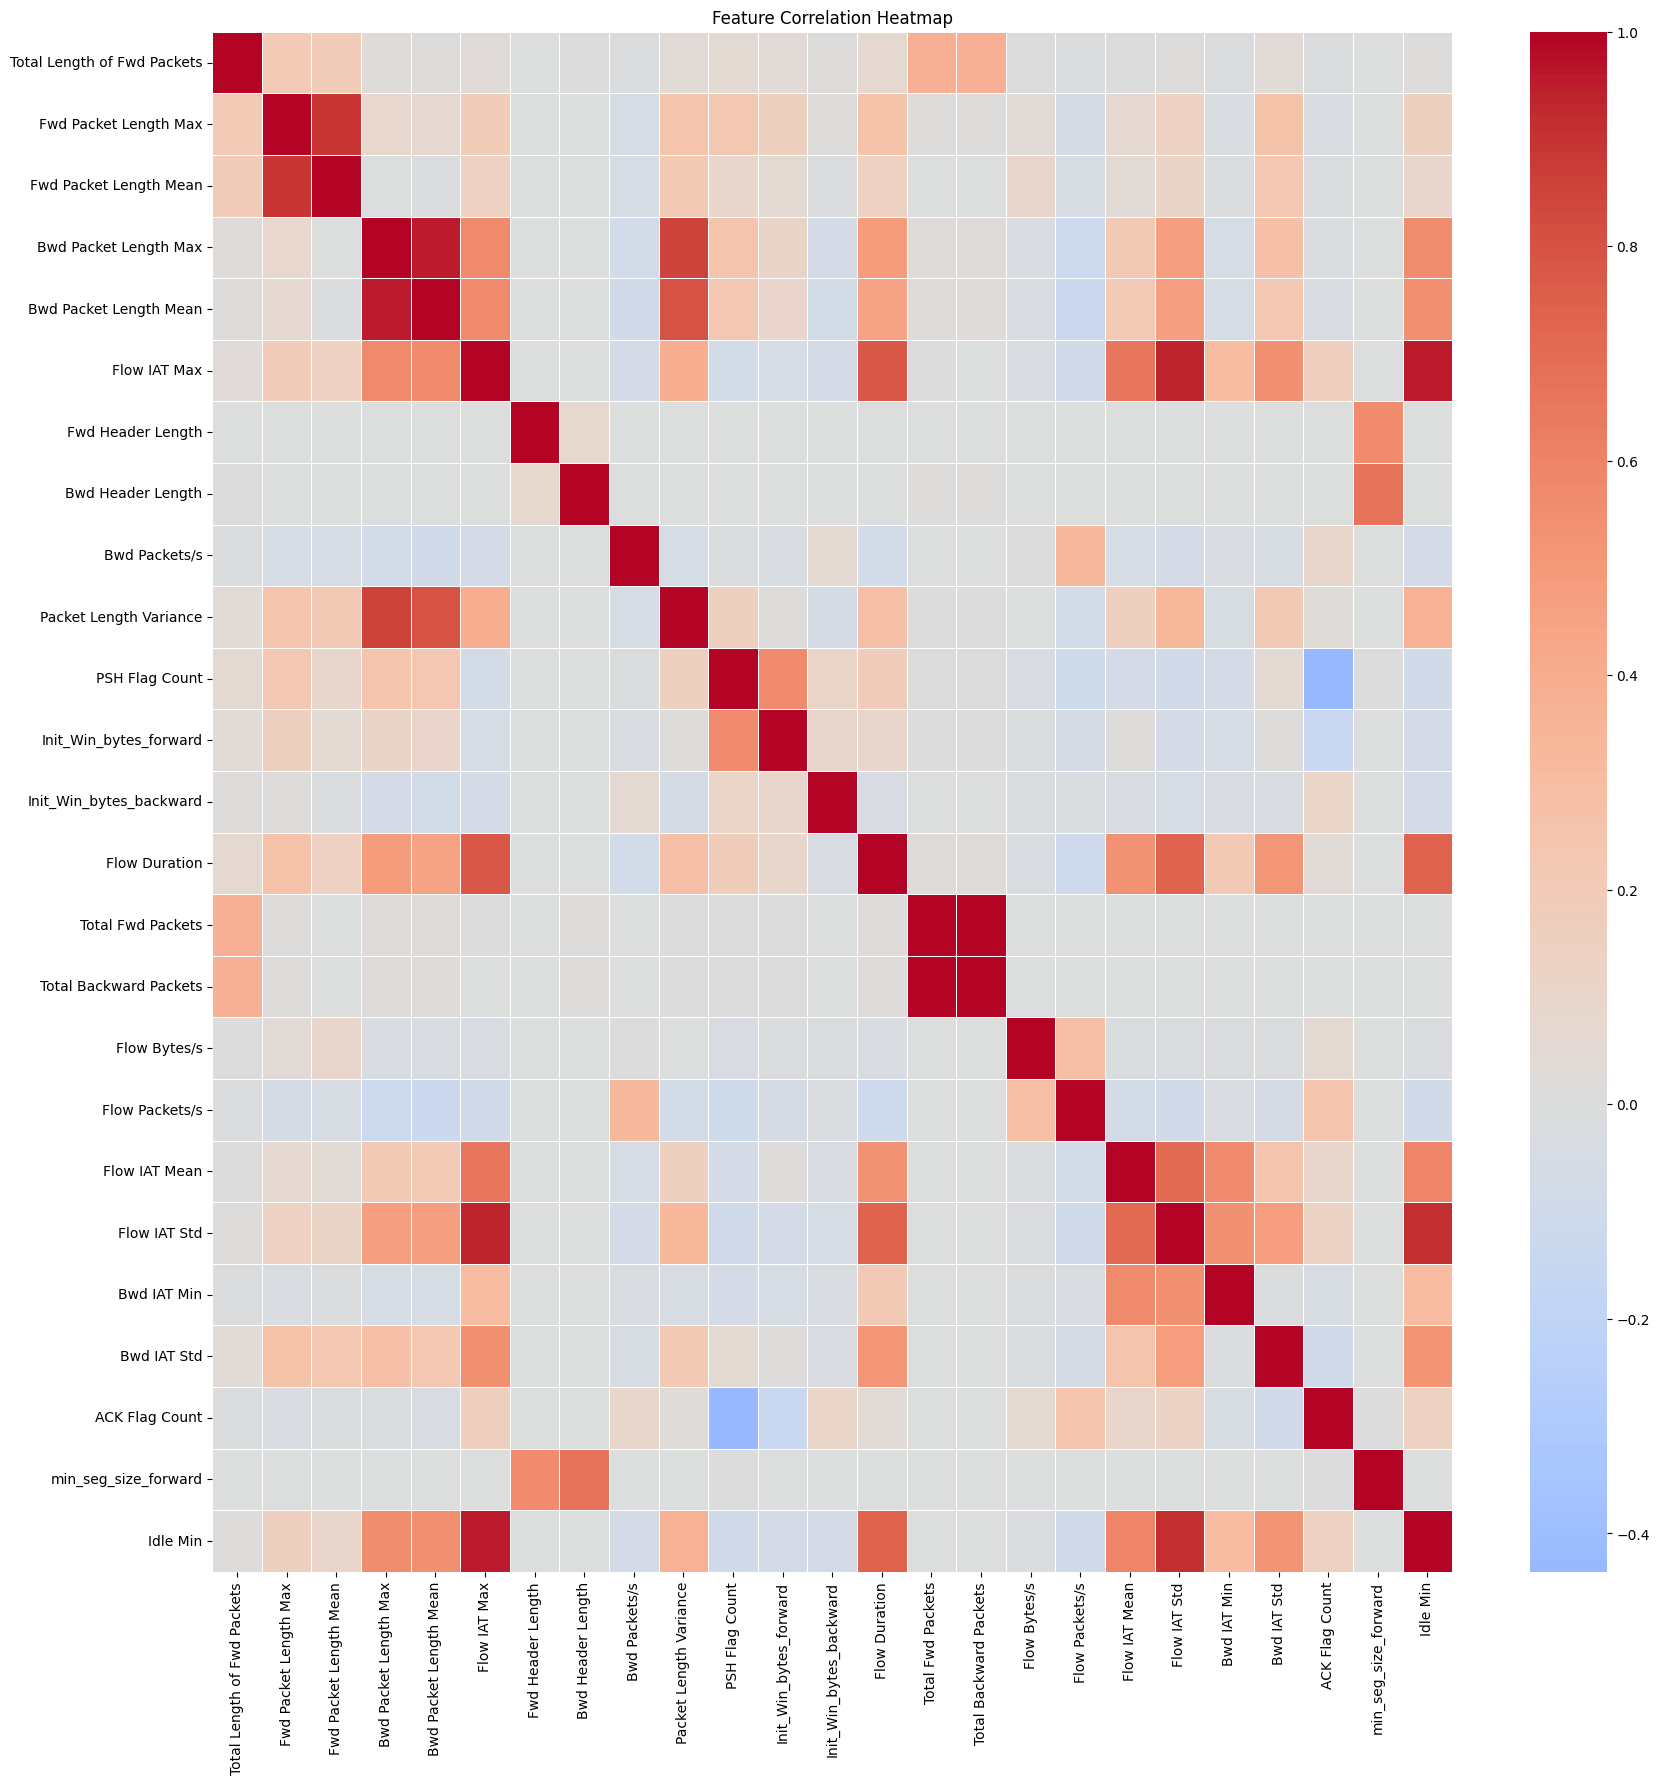

Fwd Packet Length Max has a high correlation with Fwd Packet Length Mean: 0.889
Bwd Packet Length Max has a high correlation with Bwd Packet Length Mean: 0.9582
Bwd Packet Length Max has a high correlation with Packet Length Variance: 0.852
Flow IAT Max has a high correlation with Flow IAT Std: 0.9376
Flow IAT Max has a high correlation with Idle Min: 0.9512
Total Fwd Packets has a high correlation with Total Backward Packets: 0.9991
Flow IAT Std has a high correlation with Idle Min: 0.9078


In [30]:
# Correlation Analysis:
numeric_features, categorical_features = get_feature_types(df_combined, target_col='Attack Type')
high_corr = correlation_analysis(df_combined, numeric_features)
high_multicollinearity = []
for item in high_corr:
    if item[0] == item[1]:
        continue
    print(f'{item[0]} has a high correlation with {item[1]}: {item[2].round(4)}')
    if item[2] >= 0.95:
        high_multicollinearity.append(item)

In [28]:
columns_to_drop = ["Bwd Packet Length Std", "Max Packet Length", "Packet Length Mean"]
df_combined.drop(columns=columns_to_drop, inplace=True)

In [32]:
df_combined["Attack Type"].unique()

array(['Normal Traffic', 'DDoS', 'Port Scanning', 'Bots', 'Web Attacks',
       'Brute Force', 'DoS'], dtype=object)

In [ ]:
df_combined.to_csv("cicids2017_final_sync.csv", index=False)

In [89]:
df_combined = pd.read_csv('cicids2017_final_sync.csv')

In [90]:
df_combined.columns

Index(['Unnamed: 0', 'Total Length of Fwd Packets', 'Fwd Packet Length Max',
       'Fwd Packet Length Mean', 'Bwd Packet Length Max',
       'Bwd Packet Length Mean', 'Flow IAT Max', 'Fwd Header Length',
       'Bwd Header Length', 'Bwd Packets/s', 'Packet Length Variance',
       'PSH Flag Count', 'Init_Win_bytes_forward', 'Init_Win_bytes_backward',
       'Attack Type', 'Flow Duration', 'Total Fwd Packets',
       'Total Backward Packets', 'Flow Bytes/s', 'Flow Packets/s',
       'Flow IAT Mean', 'Flow IAT Std', 'Bwd IAT Min', 'Bwd IAT Std',
       'ACK Flag Count', 'min_seg_size_forward', 'Idle Min'],
      dtype='object')

In [91]:
df_combined.drop(columns=['Unnamed: 0'], inplace=True)

In [92]:
print(df_combined['Attack Type'].value_counts())

Attack Type
Normal Traffic    2095057
DoS                193745
DDoS               128014
Port Scanning       90694
Brute Force          9150
Web Attacks          2143
Bots                 1948
Name: count, dtype: int64


In [49]:
# Mapping the attacks to the new group
group_mapping = {
    'Normal Traffic': 'Normal Traffic',
    'DoS': 'DoS',
    'DDoS': 'DDoS',
    'Brute Force': 'Brute Force',
    'Bots': 'Bots',
    'Port Scanning': 'Other',
    'Web Attacks': 'Other'
}

# Map to new group column
df_combined['Attack Type'] = df_combined['Attack Type'].map(group_mapping)

In [50]:
print(df_combined['Attack Type'].value_counts())

Attack Type
Normal Traffic    2095057
DoS                193745
DDoS               128014
Other               92837
Brute Force          9150
Bots                 1948
Name: count, dtype: int64


In [57]:
df_combined.to_csv("cicids2017_FINAL.csv")

In [52]:
df_combined.columns

Index(['Total Length of Fwd Packets', 'Fwd Packet Length Max',
       'Fwd Packet Length Mean', 'Bwd Packet Length Max',
       'Bwd Packet Length Mean', 'Flow IAT Max', 'Fwd Header Length',
       'Bwd Header Length', 'Bwd Packets/s', 'Packet Length Variance',
       'PSH Flag Count', 'Init_Win_bytes_forward', 'Init_Win_bytes_backward',
       'Attack Type', 'Flow Duration', 'Total Fwd Packets',
       'Total Backward Packets', 'Flow Bytes/s', 'Flow Packets/s',
       'Flow IAT Mean', 'Flow IAT Std', 'Bwd IAT Min', 'Bwd IAT Std',
       'ACK Flag Count', 'min_seg_size_forward', 'Idle Min'],
      dtype='object')

In [ ]:
df_combined.drop(columns=['Unnamed: 0'], inplace=True)

In [93]:
df_combined["RST Flag Count"] = df_full["RST Flag Count"]

In [58]:
df_combined.columns

Index(['Total Length of Fwd Packets', 'Fwd Packet Length Max',
       'Fwd Packet Length Mean', 'Bwd Packet Length Max',
       'Bwd Packet Length Mean', 'Flow IAT Max', 'Fwd Header Length',
       'Bwd Header Length', 'Bwd Packets/s', 'Packet Length Variance',
       'PSH Flag Count', 'Init_Win_bytes_forward', 'Init_Win_bytes_backward',
       'Attack Type', 'Flow Duration', 'Total Fwd Packets',
       'Total Backward Packets', 'Flow Bytes/s', 'Flow Packets/s',
       'Flow IAT Mean', 'Flow IAT Std', 'Bwd IAT Min', 'Bwd IAT Std',
       'ACK Flag Count', 'min_seg_size_forward', 'Idle Min', 'RST Flag Count'],
      dtype='object')

In [94]:
df_combined.drop(columns=['Init_Win_bytes_forward'], inplace=True)

In [60]:
df_combined.to_csv("cicids2017_FINAL.csv")

In [62]:
df_combined.shape

(2520751, 26)

In [64]:
df_full.columns

Index(['Destination Port', 'Flow Duration', 'Total Fwd Packets',
       'Total Backward Packets', 'Total Length of Fwd Packets',
       'Total Length of Bwd Packets', 'Fwd Packet Length Max',
       'Fwd Packet Length Min', 'Fwd Packet Length Mean',
       'Fwd Packet Length Std', 'Bwd Packet Length Max',
       'Bwd Packet Length Min', 'Bwd Packet Length Mean',
       'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s',
       'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min',
       'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max',
       'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std',
       'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Fwd URG Flags',
       'Fwd Header Length', 'Bwd Header Length', 'Fwd Packets/s',
       'Bwd Packets/s', 'Min Packet Length', 'Max Packet Length',
       'Packet Length Mean', 'Packet Length Std', 'Packet Length Variance',
       'FIN Flag Count', 'RST Flag Count', 'PSH Flag Count', 'ACK Flag Count',

In [95]:
rename_labels = {"Total Length of Fwd Packets": "TotLen Fwd Pkts",
"Fwd Packet Length Max": "Fwd Pkt Len Max",
"Fwd Packet Length Mean": "Fwd Pkt Len Mean",
"Bwd Packet Length Max": "Bwd Pkt Len Max",
"Bwd Packet Length Mean": "Bwd Pkt Len Mean",
"Flow IAT Max": "Flow IAT Max",
"Fwd Header Length": "Fwd Header Len",
"Bwd Header Length": "Bwd Header Len",
"Bwd Packets/s": "Bwd Pkts/s",
"Packet Length Variance": "Pkt Len Var",
"PSH Flag Count": "PSH Flag Cnt",
"Init_Win_bytes_backward": "Init Bwd Win Byts",
"Flow Duration": "Flow Duration",
"Total Fwd Packets": "Tot Fwd Pkts",
"Total Backward Packets": "Tot Bwd Pkts",
"Flow Bytes/s": "Flow Byts/s",
"Flow Packets/s": "Flow Pkts/s",
"Flow IAT Mean": "Flow IAT Mean",
"Flow IAT Std": "Flow IAT Std",
"Bwd IAT Min": "Bwd IAT Min",
"Bwd IAT Std": "Bwd IAT Std",
"ACK Flag Count": "ACK Flag Cnt",
"min_seg_size_forward": "Fwd Seg Size Min",
"Idle Min": "Idle Min",
"RST Flag Count": "RST Flag Cnt"}

df_combined = df_combined.rename(columns=rename_labels)

In [96]:
df_2018 = pd.read_csv('../cicids2018_prep/cicids2018_final.csv')

In [97]:
df_2018.columns

Index(['Flow Duration', 'Tot Fwd Pkts', 'Tot Bwd Pkts', 'TotLen Fwd Pkts',
       'Fwd Pkt Len Max', 'Fwd Pkt Len Mean', 'Bwd Pkt Len Max',
       'Bwd Pkt Len Mean', 'Flow Byts/s', 'Flow Pkts/s', 'Flow IAT Mean',
       'Flow IAT Std', 'Flow IAT Max', 'Bwd IAT Std', 'Bwd IAT Min',
       'Bwd Pkts/s', 'Pkt Len Var', 'RST Flag Cnt', 'ACK Flag Cnt',
       'Init Bwd Win Byts', 'Fwd Seg Size Min', 'Idle Min', 'Attack Type',
       'Fwd Header Len', 'Bwd Header Len', 'PSH Flag Cnt'],
      dtype='object')

In [71]:
df_2018.drop(columns=['Unnamed: 0'], inplace=True)

In [98]:
df_combined_columns = set(df_combined.columns)
df_2018_columns = set(df_2018.columns)

In [99]:
only_in_df1 = df_combined_columns - df_2018_columns
print(f"Columns only in first dataset: {sorted(list(only_in_df1))}")

# Columns in df2 but not in df1
only_in_df2 = df_2018_columns - df_combined_columns
print(f"Columns only in second dataset: {sorted(list(only_in_df2))}")

common_columns = df_combined_columns.intersection(df_2018_columns)
print(f"Common columns: {sorted(list(common_columns))}")


Columns only in first dataset: []
Columns only in second dataset: []
Common columns: ['ACK Flag Cnt', 'Attack Type', 'Bwd Header Len', 'Bwd IAT Min', 'Bwd IAT Std', 'Bwd Pkt Len Max', 'Bwd Pkt Len Mean', 'Bwd Pkts/s', 'Flow Byts/s', 'Flow Duration', 'Flow IAT Max', 'Flow IAT Mean', 'Flow IAT Std', 'Flow Pkts/s', 'Fwd Header Len', 'Fwd Pkt Len Max', 'Fwd Pkt Len Mean', 'Fwd Seg Size Min', 'Idle Min', 'Init Bwd Win Byts', 'PSH Flag Cnt', 'Pkt Len Var', 'RST Flag Cnt', 'Tot Bwd Pkts', 'Tot Fwd Pkts', 'TotLen Fwd Pkts']


In [78]:
df_2018.columns

Index(['Flow Duration', 'Tot Fwd Pkts', 'Tot Bwd Pkts', 'TotLen Fwd Pkts',
       'Fwd Pkt Len Max', 'Fwd Pkt Len Mean', 'Bwd Pkt Len Max',
       'Bwd Pkt Len Mean', 'Flow Byts/s', 'Flow Pkts/s', 'Flow IAT Mean',
       'Flow IAT Std', 'Flow IAT Max', 'Bwd IAT Std', 'Bwd IAT Min',
       'Bwd Pkts/s', 'Pkt Len Var', 'RST Flag Cnt', 'ACK Flag Cnt',
       'Init Bwd Win Byts', 'Fwd Seg Size Min', 'Idle Min', 'Attack Type',
       'Fwd Header Len', 'Bwd Header Len', 'PSH Flag Cnt'],
      dtype='object')

In [102]:
df_combined['Attack Type'].unique()

array(['Normal Traffic', 'DDoS', 'Port Scanning', 'Bots', 'Web Attacks',
       'Brute Force', 'DoS'], dtype=object)

In [101]:
df_combined.to_csv("cicids2017_FINAL_no_class_sync.csv", index=False)

In [4]:
df = pd.read_csv("cicids2017_FINAL_no_class_sync.csv")

In [ ]:
numeric_features, categorical_features = get_feature_types(df)

<Figure size 1500x1000 with 0 Axes>

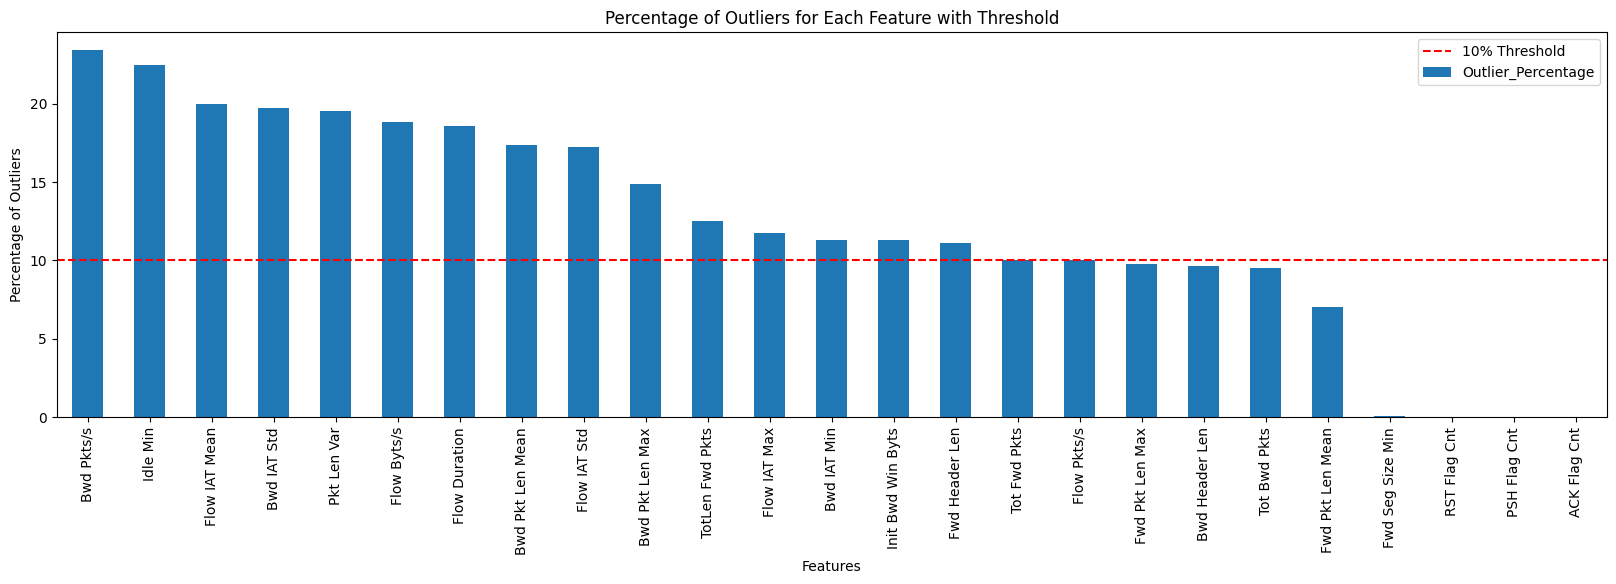

In [7]:
# Calculate outliers percentage
outlier_percentages = calculate_outliers_percentage(df[numeric_features])

# Convert to DataFrame for easier manipulation
outliers_df = pd.DataFrame.from_dict(outlier_percentages, orient='index', columns=['Outlier_Percentage'])

# Define the threshold for concern
threshold = 10

# Identify features with high percentage of outliers
high_outlier_features = outliers_df[outliers_df['Outlier_Percentage'] > threshold]

# Plot the outlier percentages and highlight features above the threshold
plt.figure(figsize=(15, 10))
outliers_df.sort_values(by='Outlier_Percentage', ascending=False).plot(kind='bar', legend=False, figsize=(20, 5))
plt.axhline(y=threshold, color='r', linestyle='--', label=f'{threshold}% Threshold')
plt.xlabel('Features')
plt.ylabel('Percentage of Outliers')
plt.title('Percentage of Outliers for Each Feature with Threshold')
plt.legend()
plt.show()